## *Jupyter Notebook* for Credit Default data 

Workflow and concepts for supervised binary classification task, more information on project jupyter and *jupyter notebooks* can be found on <link>https://jupyter.org/</link>

### Construct

Base module for doing data load and clean, and managing the workflow. *Construct* is own module

In [70]:
#-----------------
# Construct
#-----------------

import sys as sys
str_path_sys_cstr="C:\\Users\\patblo\\Python\\Scripts\\Construct"
sys.path.append(str_path_sys_cstr)

import Construct_Py36 as cstr


#-----------------
# Helper modules
#-----------------
import datetime as dt
import time as time

import os as os
import operator as operator
from collections import Counter

import numpy as np
import pandas as pd


print ("System version: {}".format(sys.version))
print ("Pandas version: {}".format(pd.__version__))
print ("Numpy version: {}".format(np.__version__))
print ("\n")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

System version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas version: 0.23.0
Numpy version: 1.14.3




### Spear

Base module for doing analytics, at the tip of data pipelines and EDA project. *Scitkit-learn* is go-to tool for doing Machine Learning in Python, more can be found on <link>https://scikit-learn.org/stable/</link>. For more classical statistical modeling, StatsModels is popular, see <link>http://www.statsmodels.org/stable/indeX_trn.html</link>.

In [71]:
#-----------------
# Construct
#-----------------

str_path_sys_spr="C:\\Users\\patblo\\Python\\Scripts\\Spear\\"
sys.path.append(str_path_sys_spr)
import Spear_Py36 as spr

#-----------------------------
# Sklearn modules + mlxtend
#-----------------------------
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,RandomForestRegressor, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence


from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, RandomizedSearchCV, train_test_split, cross_val_score, validation_curve, KFold, StratifiedKFold, StratifiedShuffleSplit, cross_validate

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE,SelectKBest

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import _name_estimators

from sklearn.externals import joblib
from sklearn.externals import six

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.base import TransformerMixin

from mlxtend.classifier import StackingCVClassifier

import operator

import lightgbm as lgbm
import xgboost as xgbst

import operator


### Options

In [72]:
# Widen notebook
from IPython.core.display import HTML, display, Image
HTML("<style>.container { width:85% !important; }</style>")

In [73]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)
pd.options.mode.chained_assignment = None

<style>
td {
  font-size: 50px
}
</style>


### Functions

In [74]:
from dateutil import relativedelta as rtd
from datetime import datetime, timedelta, date

#--------------------------------- 
# TIME DIMENSIONS
#---------------------------------
def f_this_ym():
    return dt.date.today().strftime('%Y%m')

def f_last_ym():
    return (dt.date.today() - rtd.relativedelta(months=+1)).strftime("%Y%m")

def f_last_ymd_01():
    return (dt.date.today() - rtd.relativedelta(months=+1)  - rtd.relativedelta(day = 1)).strftime("%Y%m%d")

def f_t_now():
    return dt.datetime.today().strftime("%H:%M:%S")

def f_d_now():
    return dt.date.today().strftime("%Y-%m-%d")

def f_dt_now():
    return dt.datetime.today().strftime("%Y-%m-%d %H:%M:%S")


In [10]:
#-------------------------------------
# Weight of Evidence (WoE) functions
#-------------------------------------

# Define function for estimating WoE for a discrete variable
def f_woe(exec_f, indata, list_col_woe, dict_woe_summary):
    
    """
    This function maps WoE values to a discrete ordinal or nominal categorical variable. The function also pushes back a "long form" table containing all categorical features, their
    respective values, adherent WoE values and IV values. Finally, the function return an aggregated IV table where one can do EDA to review predictive strength of the inididual 
    feature with respect to target variable.
    
    """

    if exec_f:
    
        df_tmp=indata.copy()
        
        
        
        #-----------------------------------------------
        # One input feature to calculate WoE and IV for
        #-----------------------------------------------
        if len(list_col_woe)==1:
        
            # Aggregate discrete variable and calculate metrics
            df_woe=cstr.f_grpby_aug(True, df_tmp, list_col_woe, dict_woe_summary).rename(columns={'count':'N'
                                                                                                  ,'target_sum':'target_1'
                                                                                                 ,list_col_woe[0]:'var_lvls'})
            
            df_woe['var_name']=list_col_woe[0]

        #-----------------------------------------------
        # Mor ethan one feature, we create consolidated 
        # aggregation tables for WoE and IV 
        #-----------------------------------------------
        else:
                    
            list_tmp_hld_woe=list()
        
            # Itterate over features requiring WoE and IV calculation
            for idx_col_woe, col_woe in enumerate(list_col_woe):
                
                print ("Commencing calculation of WoE and IV for variable: {}".format(col_woe))
               
                # Aggregate discrete variable and calculate metrics
                df_tmp_woe=cstr.f_grpby_aug(True, df_tmp, [col_woe], dict_woe_summary).rename(columns={'count':'N'
                                                                                            ,'target_sum':'target_1'
                                                                                            ,col_woe:'var_lvls'})                
                
                df_tmp_woe['var_name']=col_woe
                
                # Common holder
                list_tmp_hld_woe.append(df_tmp_woe)
                
            # Concat to common woe
            df_woe=pd.concat(list_tmp_hld_woe, axis=0)

        #--------------------------------
        # Generic row level calculations
        #--------------------------------
        df_woe['target_0']=df_woe['N']-df_woe['target_1']

        df_woe['p_1']=df_woe['target_1'].div(df_woe['target_1'].sum(axis=0))
        df_woe['p_0']=df_woe['target_0'].div(df_woe['target_0'].sum(axis=0))

        # WoE and IV
        df_woe['woe']=np.log10(df_woe['p_1']/df_woe['p_0'])
        df_woe['iv']=(df_woe['p_1']-df_woe['p_0'])*df_woe['woe']


        # Sort order
        df_woe=df_woe[['var_name'] + [col for col in df_woe.columns if col not in (['var_name'])]]

        # calculate IV feature level
        df_iv=df_woe[['var_name','iv']].groupby(['var_name']).sum()
        

        return df_woe, df_iv
            
            
    else:
        print ("No execution of WoE function, passing indata.")
        return indata

    
def f_dict_map_woe(exec_f, indata_woe, list_col_map_woe):
    
    """
    This function creates a dictionary of dictionaries. The dictionary keys is name of discrete ordinal and nominal categorical features. Each of the features 
    is attached to another dictionary which holds each discrete level of the variable, and an adherent WoE mapping to be applied on a pandas DataFrame. The mapping
    is done through an itteration and map on the given feature.
    
    """

    if exec_f:
        
        df_tmp=indata_woe.copy()
    
        # Hold all dictionaries for all features
        dict_hld_woe=dict()

        # Itterate over columns in WoE table
        for idx_col_dict_woe, col_dict_woe in enumerate(list_col_map_woe):
            print ("Creating a dictionary mapping of input feature WoE values for {}".format(col_dict_woe))

            df_tmp_var_woe=df_tmp[df_tmp['var_name']==col_dict_woe]
            
            dict_tmp_woe=dict(zip(df_tmp_var_woe['var_lvls'].tolist()
                                    ,df_tmp_var_woe['woe'].tolist()))

            dict_hld_woe.update({col_dict_woe:dict_tmp_woe})
            
        return dict_hld_woe
            
    else:
        print ("No execution of function for mapping discrete featrue values to WoE values, ending...")

In [11]:
def f_desc_aug(exec_f, indata, list_col_trg, list_col_metric, n_bins):
    
    """
    Docstring:

    This function takes 4 input parameters, indata in the form of a pd.DataFrame, an array with continious elements, a binary target variabe and nr of equally sized bins.
    NOTE: If n_bins is scalar, equally sized bins is created, if list then bins are created according to list elements. Finally, if None, the input metrix is assumed discrete
    and its own levels are used in the aggregation.
    
    The function return 3 objects, a pd.describe() on array in list_col_metrix, a pandas groupby table aggreation using decile bins (or other bins, given selection),
    and a seaborn distribution plot using target as hue.

    Parameters            
    exec_f                boolean(True/False): Execute function, or not
    df_temp               pd.DataFrame(), shape(n*m): indata containing features and target for analysis
    list_col_trg          list of string, 1 element: list with name of target column
    list_col_metric       list of string, 1 element: list with name of analysis metric
    n_bins                scalar, list or None: If scalar then equally sized bins. If list, the bin accordingly, if None then discrete levels of list_col_metric is used. 

    """
    
    if exec_f:

        # Set temporary working DataFrame
        df_temp=indata.copy()
        
        #----------------------------
        # Descriptive statistics
        #----------------------------
        print ("Describe:")
        display(pd.DataFrame(df_temp[list_col_metric[0]].describe()))


        #----------------------------
        # Bin and aggregate 
        #----------------------------

        # We have scalar instance of n_bins --> Create equal sized bins
        if isinstance(n_bins, int):
            # Binn
            df_temp['grp_'+list_col_metric[0]]=pd.qcut(df_temp[list_col_metric[0]], n_bins, duplicates='raise')
            df_temp['grp_'+list_col_metric[0]]=df_temp['grp_'+list_col_metric[0]].cat.codes

            # Aggrgate
            df_temp_agg=df_temp[list_col_trg+['grp_'+list_col_metric[0]]].groupby(['grp_'+list_col_metric[0]], as_index=False).agg(['count', 'sum', 'mean'])

        # We have a list instance of n_bins --> Create bins given list
        elif isinstance(n_bins, list):
            # Binn
            df_temp['grp_'+list_col_metric[0]]=pd.cut(df_temp[list_col_metric[0]], n_bins, include_lowest=True)
            df_temp['grp_'+list_col_metric[0]]=df_temp['grp_'+list_col_metric[0]].cat.codes

            # Aggrgate
            df_temp_agg=df_temp[list_col_trg+['grp_'+list_col_metric[0]]].groupby(['grp_'+list_col_metric[0]], as_index=False).agg(['count', 'sum', 'mean'])

        # n_bins is None, we use the discrete values of list_col_metric as aggregation
        else:
            print ("Ingoing metric is discrete, using its own levels for aggregation.")

            # Aggrgate
            df_temp_agg=df_temp[list_col_trg+[list_col_metric[0]]].groupby([list_col_metric[0]], as_index=False).agg(['count', 'sum', 'mean'])


        # Display aggregation
        display(df_temp_agg)


        #---------------------------------------------
        # Distribution, split on target
        #---------------------------------------------
        fig, ax=plt.subplots(ncols=1
                            ,nrows=1
                            ,figsize=(12,6))

        for trf_val in (df_temp[list_col_trg[0]].drop_duplicates()):
            sns.distplot(tuple(df_temp[df_temp[list_col_trg[0]]==trf_val][list_col_metric[0]])) 

        plt.tight_layout()
        plt.show()

        #------------------------
        # Scatter plot
        #------------------------
        
        # Using the ingoing metrics discrete levels as aggregation
        if n_bins==None:

            fig, ax=plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
            sns.regplot(x=df_temp_agg.index.values, y=df_temp_agg[('target', 'mean')], order=3,ci=None)

            plt.tight_layout()
            plt.show()

        else:
            df_temp_agg=pd.concat([df_temp_agg, df_temp[['grp_'+list_col_metric[0], list_col_metric[0]]].groupby(['grp_'+list_col_metric[0]], as_index=False).mean()[list_col_metric[0]]]
                                    ,axis=1)

            fig, ax=plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
            sns.regplot(x=df_temp_agg.index.values, y=df_temp_agg[('target', 'mean')], order=3, ci=None)

            plt.tight_layout()
            plt.show()
            
    else:
    
        print ("No execution of function, ending....")

### Paths

In [75]:
str_path_script='C:\\Users\\patblo\\Python\\Scripts\\Kaggle\\Credit Default\\'
str_path_data='C:\\Users\\patblo\\Python\\Data\\Kaggle\\Credit Default\\'

--------
## Overview
-----

## 1. Load main data

* Metadata holder (data dictionary) + column info. function
* Columns types --> List

## 2. Discrete features (objects)

    2.1 Categorical data overview, Missing values + Impute
    2.2 Discrete features visualization (given target)
    2.3 Discrete features table overview (given target)
    2.4 Transform data 
    2.5 WoE and IV
    2.6 Models
        * Logistic regression
        * Random Forrest
        * XGBoost
    
## 3. Discrete features (integers)

    3.1 Categorical data overview
    3.2 Discrete features visualization (given target)
    3.3 Discrete features table overview (given target)
    3.4 Transform data 
    3.5 WoE and IV
    3.6 Models
        * Logistic regression
        * Random Forrest
        * XGBoost
 
## 4. Continious features



## 5. Feature engineering

-----
## Data model + dictionary

The data supplied is given in an overview below - for the sake of the excercise only two tables will be used, but a much richer data set is available to explore and use for optimizing a *decision support* on the outcome of default, (0,1).

![title](home_credit_data_model - modified.png)

## Workflow

A general workflow is given below, and touch points in the notebook is outlined.

![title](ml_workflow.png)


In [13]:
import pandas as pd
import numpy as np

df_metadata=pd.read_csv(str_path_data+'HomeCredit_columns_description.csv', encoding='latin-1')
df_metadata.columns=[col.lower() for col in df_metadata.columns]
df_metadata['row']=df_metadata['row'].str.lower()
df_metadata=df_metadata[[col for col in df_metadata.columns  if col.find('unnamed')<0]]
df_metadata=df_metadata[df_metadata['table'].str.find('train')>=0]

In [14]:
def f_show_col_desc(column):
    return df_metadata.loc[df_metadata['row']==column, 'description'].values[0]

In [15]:
f_show_col_desc('target')

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

------
## 1. Load data

Load of raw data, using Pandas *read_csv* module. For more pandas information, se <link>http://pandas.pydata.org/pandas-docs/stable/reference/index.html</link>, created by Wes Mckinney <link>http://wesmckinney.com/</link>. Pandas is used extensively for heavy lifting when reading data, transforming and loading into different formats (files, data bases, API, etc.). Pandas is built on top of Numpy, which is used for numerical computation and matrix algebra in Python - for more information on Numpy, see <link>http://www.numpy.org/</link>. 

1. Load main data, in raw format, being application data on credit products. This data hold targe and features describing the outcome event on each event, being adverse payment behavior in an unspcified time horizon since having loan approved(0,1).
2. Load bureau data to add some further descriptive information to each application/applicant

In [16]:
import pandas as pd
import numpy as np

# Helper function for data raw load and overview
def f_load_raw_csv(exec_f, str_path):
    
    if exec_f:
        
        import time as time
        
        tick=time.time()
        
        # Read csv
        df_temp=pd.read_csv(str_path)
        
        # Check dimensionality
        dim_ax0, dim_ax1=df_temp.shape[0], df_temp.shape[1]
        srs_isnull=df_temp.isnull().sum(axis=0)
        
        # What do we have in there?
        print ("\nDimensionality of data is: {}. We have at most {} missing values in one column, being {:0.3f}% of total rows.".format((dim_ax0, dim_ax1), srs_isnull.max(axis=0), 100*(srs_isnull.max(axis=0)/dim_ax0)))
        
        # We do one simple transformation and set all columns to lower case
        df_temp.columns=[col.lower() for col in df_temp.columns]
        
        print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))
        
        # Return DataFrame object
        return df_temp
        
    else:
        print ("No execution of function, ending....")

In [17]:
df_application=f_load_raw_csv(True, str_path_data+'application_train.csv')


Dimensionality of data is: (307511, 122). We have at most 214865 missing values in one column, being 69.872% of total rows.

Total elapsed time is: 7s


Thats a fairly high dimensionaltiy on the main application data, 122 columns in total. Lets look at the first few rows to get a sense of whats in there.

In [18]:
# Top 5 rows
df_application[:5]

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Let see how things are defined with respect to the target variable.

In [19]:
f_show_col_desc('target')

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

 In the application data we have a big set of standard features, i.e. descriptive attributes of the applicant with respect to their financial situation. In addition to this we also have  additional parameters which might not be common in normal burea data, e.g. *floorsmax_medi*. Let see how this is defined:

In [20]:
f_show_col_desc('floorsmax_medi')

'Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor'

This really give good groundwork for making a complex deicision with respect to the potential payment behavior on the loan applicant! However, given the information specified above, lets select out only the columns from the application variables where we are dont have *average*, *modus* and *median*. This will allow of to focus more on classical lending applicatinon variables, and disgard data connected to the applicants residential situation. No particular value is attributed to the choice, its merely done for reducing things in a, somewhat, arbitrary way for more easy management and visualization.  

In [21]:
# Get all columns related to housing, flagged by holding '_avg', '_mode', or '_medi'
list_col_resid=[col for col in df_application.columns if col.find('avg')>=0 or col.find('mode')>=0 or col.find('medi')>=0]

# we remove all housing statistics variables, and focus on financial information
df_applications_sub=df_application[[col for col in df_application.columns if col not in list_col_resid]]

print ("Total dimensionality of data is: {}".format(df_applications_sub.shape))

Total dimensionality of data is: (307511, 75)


Given the above "fast forward" handling of a big set of variables, we end up with something more managable. In order to make a more numerically grounded decision with respect to variale importance, and how to proceed with an initial selection, lets take some help from *Weight of Evidence* (WoE) and its adherent univariate statistic *Information Value* (IV) to get a feeling for the different possible strong predictors.
<br>

But first, lets review column types and missing values, and make some changes to the names to set notation more appropriate.



In [22]:
print ("Count of total variables is: {}. Variable types is distributed in the following way:".format(len(df_applications_sub.columns)))
display(df_applications_sub.get_dtype_counts())

Count of total variables is: 75. Variable types is distributed in the following way:


int64      41
object     12
float64    22
dtype: int64

Given above, we will have at least a few variable that need to go from text form into some sort of numerical representation. Let start with them and see of we can gauge some predictive power!  We will at the same time put all columns in separate holders so we can easily access them, i.e. *object* goes into one "container", *integers* into another one, and *float* variables into a third. 

#### Column list holders

Create to hold column types in order to efficiently slice and fetch data 

In [23]:
# Check table metadata, make temp table for holdin info and split by column type, into list for subset
df_meta_application_tmp=pd.DataFrame(df_applications_sub.dtypes).reset_index()
df_meta_application_tmp.columns=['col_name', 'col_type']

# Containers for holding variavle names for easy access
list_col_obj=df_meta_application_tmp[df_meta_application_tmp['col_type']=='object']['col_name'].tolist()
list_col_int=df_meta_application_tmp[(df_meta_application_tmp['col_type']=='int64') & ~(df_meta_application_tmp['col_name'].isin(['target', 'sk_id_curr']))]['col_name'].tolist()
list_col_float=df_meta_application_tmp[(df_meta_application_tmp['col_type']=='float64') & ~(df_meta_application_tmp['col_name'].isin(['target', 'sk_id_curr']))]['col_name'].tolist()
list_col_meta=['sk_id_curr', 'target']

----
## 2. Data overview

* Table overview
* Visualization of discrete data
* Discrete table overview

### 2.1 Table overview of the discrete object features

In [24]:
tick=time.time()

df_overv_int, df_overv_obj=cstr.f_table_overv(True, df_applications_sub[['target']+list_col_obj], ['None'], sclr_disc_cutoff=100)
df_overv_obj.drop('unique', inplace=True, axis=1)

def f_meta_df_over_disc_obj(exec_f, indata):
    if exec_f:
        df_temp_meta=indata.copy()
        
        #---------------------
        # rename columns
        #---------------------
        df_temp_meta['col_rename']=np.where(df_temp_meta['unq_val_cnt']==2
                                           ,'inp_f_'+df_temp_meta['col_name']
                                           ,'inp_grp_'+df_temp_meta['col_name']
                                           )
        
        #--------------------
        # Impute strategy
        #--------------------
        df_temp_meta['col_imp_strg']=np.where(df_temp_meta['%_null_tot']==0
                                              ,'NoNaN'
                                              ,'MaxValDisc')
        
        #-------------------
        # Sort order
        #-------------------
        list_col_srt_ord=['col_name','col_type','col_rename','col_imp_strg']
        df_temp_meta=df_temp_meta[list_col_srt_ord+[col for col in df_temp_meta.columns if col not in list_col_srt_ord]]
        
        
        # return meta
        return df_temp_meta
        
    else:
        print ("No execution of function, retuning indata....")
        return indata


df_overv_obj=f_meta_df_over_disc_obj(True, df_overv_obj)
print ("Total elapsed time is: {}s".format(round(time.time()-tick, 2)))

df_overv_obj

Columns float: []
Columns int: ['target']

All numerical columns: ['target']
Columns date: []
Columns object/string: ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type', 'weekday_appr_process_start', 'organization_type']

All other columns: ['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type', 'weekday_appr_process_start', 'organization_type']
Total elapsed time is: 1.39s


,col_name,col_type,col_rename,col_imp_strg,isnull_cnt,unq_val_cnt,n_rows_tot,%_null_tot,top,freq
0,name_contract_type,object,inp_f_name_contract_type,NoNaN,0,2,307511,0.000000,Cash loans,278232
1,code_gender,object,inp_grp_code_gender,NoNaN,0,3,307511,0.000000,F,202448
2,flag_own_car,object,inp_f_flag_own_car,NoNaN,0,2,307511,0.000000,N,202924
3,flag_own_realty,object,inp_f_flag_own_realty,NoNaN,0,2,307511,0.000000,Y,213312
4,name_type_suite,object,inp_grp_name_type_suite,MaxValDisc,1292,8,307511,0.004201,Unaccompanied,248526
5,name_income_type,object,inp_grp_name_income_type,NoNaN,0,8,307511,0.000000,Working,158774
6,name_education_type,object,inp_grp_name_education_type,NoNaN,0,5,307511,0.000000,Secondary / secondary special,218391
7,name_family_status,object,inp_grp_name_family_status,NoNaN,0,6,307511,0.000000,Married,196432
8,name_housing_type,object,inp_grp_name_housing_type,NoNaN,0,6,307511,0.000000,House / apartment,272868
9,occupation_type,object,inp_grp_occupation_type,MaxValDisc,96391,19,307511,0.313455,Laborers,55186


Lets have a look at the columns with missing values!

In [25]:
def f_discr_tbl_agg(exec_f, indata, list_col_grpby):
    
    if exec_f:
        
        df_temp=indata.copy()
        
        print ("Total rows is: {}, overall bad rate is: {:0.3f}%".format(len(df_temp), 100*df_temp['target'].mean(axis=0)))

        for idx_col, col_grpby in enumerate(list_col_grpby):
            print ("\nColum being analyzed is: {}".format(col_grpby))
            df_agg_temp=df_temp[['target']+[col_grpby]].groupby([col_grpby], as_index=False).agg(['count', 'sum', 'mean']).reset_index()
            df_agg_temp['%_count_of_total']=df_agg_temp['target']['count']/len(df_temp)
            display(df_agg_temp)

    else:
        print ("No execution of function, ending....")

In [26]:
f_discr_tbl_agg(True, df_applications_sub,['occupation_type','name_type_suite'])

Total rows is: 307511, overall bad rate is: 8.073%

Colum being analyzed is: occupation_type


occupation_type target                 %_count_of_total
                           count   sum      mean                 
0             Accountants   9813   474  0.048303         0.031911
1          Cleaning staff   4653   447  0.096067         0.015131
2           Cooking staff   5946   621  0.104440         0.019336
3              Core staff  27570  1738  0.063040         0.089655
4                 Drivers  18603  2107  0.113261         0.060495
5                HR staff    563    36  0.063943         0.001831
6   High skill tech staff  11380   701  0.061599         0.037007
7                IT staff    526    34  0.064639         0.001711
8                Laborers  55186  5838  0.105788         0.179460
9      Low-skill Laborers   2093   359  0.171524         0.006806
10               Managers  21371  1328  0.062140         0.069497
11         Medicine staff   8537   572  0.067002         0.027762
12  Private service staff   2652   175  0.065988         0.008624
13          Realty agents    751    59  0.078562         0.002442
14            Sales staff  32102  3092  0.096318         0.104393
15            Secretaries   1305    92  0.070498         0.004244
16         Security staff   6721   722  0.107424         0.021856
17   Waiters/barmen staff   1348   152  0.112760         0.004384


Colum being analyzed is: name_type_suite


name_type_suite  target                  %_count_of_total
                     count    sum      mean                 
0         Children    3267    241  0.073768         0.010624
1           Family   40149   3009  0.074946         0.130561
2  Group of people     271     23  0.084871         0.000881
3          Other_A     866     76  0.087760         0.002816
4          Other_B    1770    174  0.098305         0.005756
5  Spouse, partner   11370    895  0.078716         0.036974
6    Unaccompanied  248526  20337  0.081830         0.808186

Missing values:

1. **occupation_type**

Given the high % of missing values, and high level of nr of unique levels in the variable, there is risk of introducing bias when imputing. The variable has, however, good variation in bad rate between different occupations, and removing it completly might influence model performance. Given this the most frequent discrete level is used for impuation. 
<br><br>
2. **name_type_suite**,

Here we have a very low level of missing values, a resonable approach is to fill the missing values with the most common occuring discrete value being unaccompanied.

In [27]:
# Fill name_type_suite value with most common
df_applications_sub['name_type_suite'].fillna('Unaccompanied', inplace=True)
df_applications_sub['occupation_type'].fillna('Laborers', inplace=True)

Given our 12 variable here, we have a decent view of the nr of unique levels. Lets make a grid of the variables and plot their mean bad rate. Lets leave *organization_type* for now since its has alot of unique levels and might need to be handeled separately.

Here we take the data from *wide format*, i.e. we have one row per application, to *long format* were we stack the variables we want to plot on top of eachother. The tools used for illustrating the discrete variables is seaborn, a popular tool for visualization. See <link>https://seaborn.pydata.org/</link>

### 2.2 Discrete data visualization

Transform *wide* to *long*

C:\Users\patblo\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


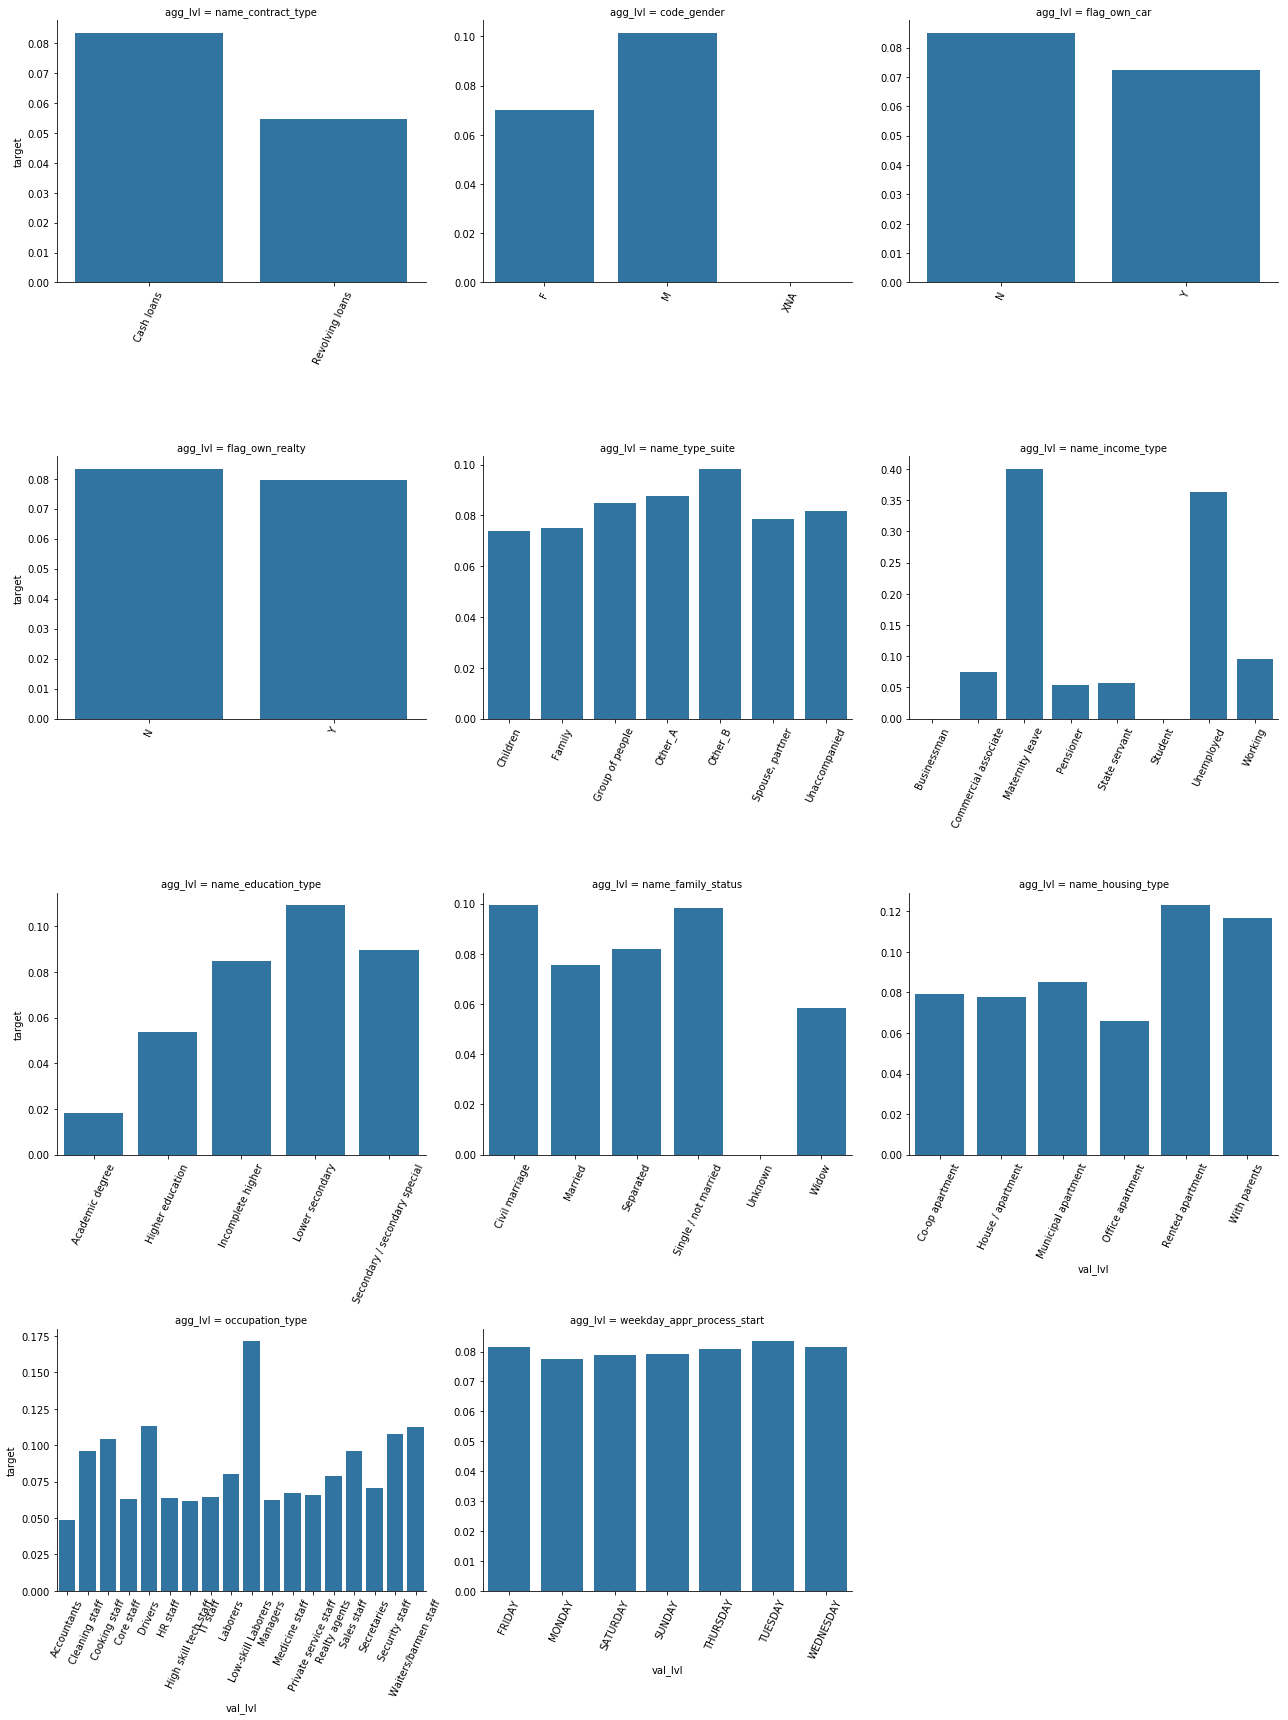

In [28]:
# Hold modified data
list_hld_grpby=list()

list_col_obj_grpby=[col for col in list_col_obj if col not in (['sk_id_curr','target','organization_type'])]

# Work through all discrete columns and calculate mean of target (Basically go from "wide" to "long")
for grp_col in list_col_obj_grpby:
    df_agg_tmp=df_applications_sub[['target']+[grp_col]].groupby([grp_col],as_index=False).mean()
    df_agg_tmp.rename(columns={grp_col:'val_lvl'}, inplace=True)
    df_agg_tmp['agg_lvl']=grp_col

    # Add to holder
    list_hld_grpby.append(df_agg_tmp)

# Combine to common
df_mlt_agg=pd.concat(list_hld_grpby,sort=True)

# Initialize grid, and fill with individual barplot objects
g=sns.FacetGrid(df_mlt_agg, col='agg_lvl', col_wrap=3, sharex=False, sharey=False, height=6)
g.map(sns.barplot, 'val_lvl','target')

# Rotate ticks so high freq discrete x-axis values dont overlap
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

# Tight layout and show()
plt.tight_layout()
plt.show()

We clearly see a few patterns which might make sense from a hypothetical standpoint given strength in payment behavior. For example, if you have an academic eduation, you ar less likely to become late with payments. If you, on the other hand, live in an rented apartment, the propensity for being late is relatively higher.

Lets take this one step further and create a few discrete aggregations tables to see the actual numbers in each categorical level. We create a function which we easily can re-use.

### 2.3 Discrete feature table overview

In [29]:
# We add back organization type since the nr unique levels isnt a problem here
f_discr_tbl_agg(True, df_applications_sub, list_col_obj_grpby+['organization_type'])

Total rows is: 307511, overall bad rate is: 8.073%

Colum being analyzed is: name_contract_type


name_contract_type  target                  %_count_of_total
                       count    sum      mean                 
0         Cash loans  278232  23221  0.083459         0.904787
1    Revolving loans   29279   1604  0.054783         0.095213


Colum being analyzed is: code_gender


code_gender  target                  %_count_of_total
                count    sum      mean                 
0           F  202448  14170  0.069993         0.658344
1           M  105059  10655  0.101419         0.341643
2         XNA       4      0  0.000000         0.000013


Colum being analyzed is: flag_own_car


flag_own_car  target                  %_count_of_total
                 count    sum      mean                 
0            N  202924  17249  0.085002         0.659892
1            Y  104587   7576  0.072437         0.340108


Colum being analyzed is: flag_own_realty


flag_own_realty  target                  %_count_of_total
                    count    sum      mean                 
0               N   94199   7842  0.083249         0.306327
1               Y  213312  16983  0.079616         0.693673


Colum being analyzed is: name_type_suite


name_type_suite  target                  %_count_of_total
                     count    sum      mean                 
0         Children    3267    241  0.073768         0.010624
1           Family   40149   3009  0.074946         0.130561
2  Group of people     271     23  0.084871         0.000881
3          Other_A     866     76  0.087760         0.002816
4          Other_B    1770    174  0.098305         0.005756
5  Spouse, partner   11370    895  0.078716         0.036974
6    Unaccompanied  249818  20407  0.081687         0.812387


Colum being analyzed is: name_income_type


name_income_type  target                  %_count_of_total
                          count    sum      mean                 
0           Businessman      10      0  0.000000         0.000033
1  Commercial associate   71617   5360  0.074843         0.232892
2       Maternity leave       5      2  0.400000         0.000016
3             Pensioner   55362   2982  0.053864         0.180033
4         State servant   21703   1249  0.057550         0.070576
5               Student      18      0  0.000000         0.000059
6            Unemployed      22      8  0.363636         0.000072
7               Working  158774  15224  0.095885         0.516320


Colum being analyzed is: name_education_type


name_education_type  target                  %_count_of_total
                                   count    sum      mean                 
0                Academic degree     164      3  0.018293         0.000533
1               Higher education   74863   4009  0.053551         0.243448
2              Incomplete higher   10277    872  0.084850         0.033420
3                Lower secondary    3816    417  0.109277         0.012409
4  Secondary / secondary special  218391  19524  0.089399         0.710189


Colum being analyzed is: name_family_status


name_family_status  target                  %_count_of_total
                          count    sum      mean                 
0        Civil marriage   29775   2961  0.099446         0.096826
1               Married  196432  14850  0.075599         0.638780
2             Separated   19770   1620  0.081942         0.064290
3  Single / not married   45444   4457  0.098077         0.147780
4               Unknown       2      0  0.000000         0.000007
5                 Widow   16088    937  0.058242         0.052317


Colum being analyzed is: name_housing_type


name_housing_type  target                  %_count_of_total
                         count    sum      mean                 
0      Co-op apartment    1122     89  0.079323         0.003649
1    House / apartment  272868  21272  0.077957         0.887344
2  Municipal apartment   11183    955  0.085397         0.036366
3     Office apartment    2617    172  0.065724         0.008510
4     Rented apartment    4881    601  0.123131         0.015873
5         With parents   14840   1736  0.116981         0.048258


Colum being analyzed is: occupation_type


occupation_type  target                  %_count_of_total
                            count    sum      mean                 
0             Accountants    9813    474  0.048303         0.031911
1          Cleaning staff    4653    447  0.096067         0.015131
2           Cooking staff    5946    621  0.104440         0.019336
3              Core staff   27570   1738  0.063040         0.089655
4                 Drivers   18603   2107  0.113261         0.060495
5                HR staff     563     36  0.063943         0.001831
6   High skill tech staff   11380    701  0.061599         0.037007
7                IT staff     526     34  0.064639         0.001711
8                Laborers  151577  12116  0.079933         0.492916
9      Low-skill Laborers    2093    359  0.171524         0.006806
10               Managers   21371   1328  0.062140         0.069497
11         Medicine staff    8537    572  0.067002         0.027762
12  Private service staff    2652    175  0.065988         0.008624
13          Realty agents     751     59  0.078562         0.002442
14            Sales staff   32102   3092  0.096318         0.104393
15            Secretaries    1305     92  0.070498         0.004244
16         Security staff    6721    722  0.107424         0.021856
17   Waiters/barmen staff    1348    152  0.112760         0.004384


Colum being analyzed is: weekday_appr_process_start


weekday_appr_process_start target                 %_count_of_total
                              count   sum      mean                 
0                     FRIDAY  50338  4101  0.081469         0.163695
1                     MONDAY  50714  3934  0.077572         0.164918
2                   SATURDAY  33852  2670  0.078873         0.110084
3                     SUNDAY  16181  1283  0.079291         0.052619
4                   THURSDAY  50591  4098  0.081003         0.164518
5                    TUESDAY  53901  4501  0.083505         0.175282
6                  WEDNESDAY  51934  4238  0.081604         0.168885


Colum being analyzed is: organization_type


organization_type target                 %_count_of_total
                            count   sum      mean                 
0              Advertising    429    35  0.081585         0.001395
1              Agriculture   2454   257  0.104727         0.007980
2                     Bank   2507   130  0.051855         0.008153
3   Business Entity Type 1   5984   487  0.081384         0.019459
4   Business Entity Type 2  10553   900  0.085284         0.034317
5   Business Entity Type 3  67992  6323  0.092996         0.221104
6                 Cleaning    260    29  0.111538         0.000845
7             Construction   6721   785  0.116798         0.021856
8                  Culture    379    21  0.055409         0.001232
9              Electricity    950    63  0.066316         0.003089
10               Emergency    560    40  0.071429         0.001821
11              Government  10404   726  0.069781         0.033833
12                   Hotel    966    62  0.064182         0.003141
13                 Housing   2958   235  0.079446         0.009619
14        Industry: type 1   1039   115  0.110683         0.003379
15       Industry: type 10    109     7  0.064220         0.000354
16       Industry: type 11   2704   234  0.086538         0.008793
17       Industry: type 12    369    14  0.037940         0.001200
18       Industry: type 13     67     9  0.134328         0.000218
19        Industry: type 2    458    33  0.072052         0.001489
20        Industry: type 3   3278   348  0.106162         0.010660
21        Industry: type 4    877    89  0.101482         0.002852
22        Industry: type 5    599    41  0.068447         0.001948
23        Industry: type 6    112     8  0.071429         0.000364
24        Industry: type 7   1307   105  0.080337         0.004250
25        Industry: type 8     24     3  0.125000         0.000078
26        Industry: type 9   3368   225  0.066805         0.010952
27               Insurance    597    34  0.056951         0.001941
28            Kindergarten   6880   484  0.070349         0.022373
29          Legal Services    305    24  0.078689         0.000992
30                Medicine  11193   737  0.065845         0.036399
31                Military   2634   135  0.051253         0.008566
32                  Mobile    317    29  0.091483         0.001031
33                   Other  16683  1275  0.076425         0.054252
34                  Police   2341   117  0.049979         0.007613
35                  Postal   2157   182  0.084376         0.007014
36                 Realtor    396    42  0.106061         0.001288
37                Religion     85     5  0.058824         0.000276
38              Restaurant   1811   212  0.117062         0.005889
39                  School   8893   526  0.059148         0.028919
40                Security   3247   324  0.099784         0.010559
41     Security Ministries   1974    96  0.048632         0.006419
42           Self-employed  38412  3908  0.101739         0.124913
43                Services   1575   104  0.066032         0.005122
44                 Telecom    577    44  0.076256         0.001876
45           Trade: type 1    348    31  0.089080         0.001132
46           Trade: type 2   1900   133  0.070000         0.006179
47           Trade: type 3   3492   361  0.103379         0.011356
48           Trade: type 4     64     2  0.031250         0.000208
49           Trade: type 5     49     3  0.061224         0.000159
50           Trade: type 6    631    29  0.045959         0.002052
51           Trade: type 7   7831   740  0.094496         0.025466
52       Transport: type 1    201     9  0.044776         0.000654
53       Transport: type 2   2204   172  0.078040         0.007167
54       Transport: type 3   1187   187  0.157540         0.003860
55       Transport: type 4   5398   501  0.092812         0.017554
56              University   1327    65  0.048983         0.004315
57                     XNA  55374  2990  0.053996       

Since *organization_type* has a high level of unique values, we take a side-step and analyse it separately!

In [30]:
df_temp=df_applications_sub[['sk_id_curr', 'target', 'organization_type']].copy()

# Organization type is aggregated by splitting out prefix tags on adherency for the given org, i.e. Trade: Type 7 --> Trade.
df_temp['inp_grp_org_type_agg']=df_temp['organization_type'].str.split(':').str.get(0)

# We call our discrete table function again and review its distribution
f_discr_tbl_agg(True, df_temp, ['inp_grp_org_type_agg'])

Total rows is: 307511, overall bad rate is: 8.073%

Colum being analyzed is: inp_grp_org_type_agg


inp_grp_org_type_agg target                 %_count_of_total
                            count   sum      mean                 
0              Advertising    429    35  0.081585         0.001395
1              Agriculture   2454   257  0.104727         0.007980
2                     Bank   2507   130  0.051855         0.008153
3   Business Entity Type 1   5984   487  0.081384         0.019459
4   Business Entity Type 2  10553   900  0.085284         0.034317
5   Business Entity Type 3  67992  6323  0.092996         0.221104
6                 Cleaning    260    29  0.111538         0.000845
7             Construction   6721   785  0.116798         0.021856
8                  Culture    379    21  0.055409         0.001232
9              Electricity    950    63  0.066316         0.003089
10               Emergency    560    40  0.071429         0.001821
11              Government  10404   726  0.069781         0.033833
12                   Hotel    966    62  0.064182         0.003141
13                 Housing   2958   235  0.079446         0.009619
14                Industry  14311  1231  0.086018         0.046538
15               Insurance    597    34  0.056951         0.001941
16            Kindergarten   6880   484  0.070349         0.022373
17          Legal Services    305    24  0.078689         0.000992
18                Medicine  11193   737  0.065845         0.036399
19                Military   2634   135  0.051253         0.008566
20                  Mobile    317    29  0.091483         0.001031
21                   Other  16683  1275  0.076425         0.054252
22                  Police   2341   117  0.049979         0.007613
23                  Postal   2157   182  0.084376         0.007014
24                 Realtor    396    42  0.106061         0.001288
25                Religion     85     5  0.058824         0.000276
26              Restaurant   1811   212  0.117062         0.005889
27                  School   8893   526  0.059148         0.028919
28                Security   3247   324  0.099784         0.010559
29     Security Ministries   1974    96  0.048632         0.006419
30           Self-employed  38412  3908  0.101739         0.124913
31                Services   1575   104  0.066032         0.005122
32                 Telecom    577    44  0.076256         0.001876
33                   Trade  14315  1299  0.090744         0.046551
34               Transport   8990   869  0.096663         0.029235
35              University   1327    65  0.048983         0.004315
36                     XNA  55374  2990  0.053996         0.180072

### 2.4. Transform

Its obvious that we have a lot of categorical levels in different variables with a small representation in data. Lets create a transform function where we group a few of the levels into something common in order to handle the potential problem of bias better. Some things can possibly be excluded, and some things can be a direct *policy reject* in order to reduce potential adverse payment behavior.

**The following rules are applied, and coded into the system:**

1. *code_gender*
    * xNA             --> Excluded 
<br><br>
2. *name_income_type*
    * materinty leave --> 'Manual handling' (rows excluded from modeling)
    * student         --> 'Manual handling' (rows excluded from modeling)
    * Unemployed      --> Policy reject (target override, set to 1)
    * Businessman     --> re-coded into *state servant*, and cross-validated
<br><br>
3. *name_education_type*
    * Academic degree ---> re-coded into *higher education*, and cross-validated
<br><br>
4. *name_family_status*
    * Unknown         ---> Excluded      
    
**NOTE:** Code is written parameterized to be able to function in an production environment! 

In [31]:
def f_trf_application_obj(exec_f, indata, indata_meta):
    
    if exec_f:
        
        df_temp=indata.copy()
        df_temp_meta=indata_meta.copy()
        
        #-------------------------
        # name_contract_type
        #-------------------------

        df_temp['inp_f_contract_type']=np.where(df_temp['name_contract_type']=='Revolving loans'
                                               ,1
                                               ,0)
        
        #-------------------------
        # code_gender
        #-------------------------
        df_temp['inp_f_gender']=np.where(df_temp['code_gender']=='M'
                                    ,1
                                    ,np.where(df_temp['code_gender']=='F'
                                             ,0
                                             ,-99)
                                    )
        
        # Flag exclusion
        df_temp.loc[df_temp['inp_f_gender']==-99, 'f_excl']=1
        df_temp.loc[df_temp['inp_f_gender']==-99, 'grp_excl_desc']='Deviating gender code'


        
        #-------------------------
        # flag_own_car
        #-------------------------
        df_temp['inp_f_own_car']=np.where(df_temp['flag_own_car']=='Y'
                                     ,1
                                     ,0)

        #-------------------------
        # flag_own_realty
        #-------------------------
        df_temp['inp_f_own_realty']=np.where(df_temp['flag_own_realty']=='Y'
                                     ,1
                                     ,0)
        

        # drop columns
        df_temp.drop(['code_gender', 'flag_own_car','flag_own_realty'],inplace=True, axis=1)

        
        
        #-------------------------
        # name_income_type ()
        #-------------------------
        dict_map_name_inc_type={'Maternity leave':'-99'
                               ,'Student':'-99'
                               ,'Unemployed':'-99'
                               ,'Businessman':'State servant'
                               ,'Working':'Working'
                               ,'State servant':'State servant'
                               ,'Commercial associate':'Commerical associate'
                               ,'Pensioner':'Pensioner'
                               }
        
        df_temp['inp_grp_name_income_type_agg']=df_temp['name_income_type'].map(dict_map_name_inc_type)

        # flag exclusion
        df_temp.loc[df_temp['name_education_type']=='Maternity leave', 'f_excl']=1
        df_temp.loc[df_temp['name_education_type']=='Maternity leave', 'grp_excl_desc']='Maternity leave, policy reject. target=1'

        df_temp.loc[df_temp['name_education_type']=='Student', 'f_excl']=1
        df_temp.loc[df_temp['name_education_type']=='Student', 'grp_excl_desc']='Student, manual handling...'
        
        df_temp.loc[df_temp['name_education_type']=='Unemployed', 'f_excl']=1
        df_temp.loc[df_temp['name_education_type']=='Unemployed', 'grp_excl_desc']='Unemployed, policy reject. target=1'

    
        #-------------------------
        # name_education_type ()
        #-------------------------
        df_temp['inp_grp_name_educ_type_agg']=np.where(df_temp['name_education_type']=='Academic degree'
                                                      ,'Higher education'
                                                      ,df_temp['name_education_type'])
        
        
        # flag exclusion
        df_temp.loc[df_temp['name_education_type']=='Unknown', 'f_excl']=1
        df_temp.loc[df_temp['name_education_type']=='Unknown', 'grp_excl_desc']='Unknow education type, nr unique < 0.001%'

        
        #-------------------------
        # name_family_status
        #-------------------------
        
        df_temp['inp_grp_name_fam_status']=df_temp['name_family_status']
        
        # flag exclusion
        df_temp.loc[df_temp['name_family_status']=='Unknown', 'f_excl']=1
        df_temp.loc[df_temp['name_family_status']=='Unknown', 'grp_excl_desc']='Unknow family status, nr unique < 0.001%'
        
        #-------------------------
        # organization_type
        #-------------------------
        
        df_temp['inp_grp_org_type_agg']=df_temp['organization_type'].str.split(':').str.get(0)

        
        #----------------------------------------
        # Rename columns not being transformed
        #----------------------------------------
        list_col_rename=['name_type_suite', 'name_housing_type', 'weekday_appr_process_start']

        df_temp.rename(columns=dict(zip(list_col_rename, ['inp_grp_'+col for col in list_col_rename])), inplace=True)
        
        
        
        
        # Return transformed data
        return df_temp
    
    else:
        
        print ("No execution of function, returning indata...")
        return indata

In [32]:
df_applications_sub=f_trf_application_obj(True, df_applications_sub, df_overv_obj)

In [33]:
#-------------------------------------------------
# Remove exclusion rows and put them 
# in a separate data table for east access
#-------------------------------------------------
df_application_excl=df_applications_sub[df_applications_sub['f_excl']==1]

# Non-excluded
df_trf_application_sub=df_applications_sub[df_applications_sub['f_excl'].isna()]

### 2.5 Introducing Weight of Evidence (WoE)

Weight of Evidence has been used in the credit scoring industry as a means to transform discrete variables into a dimension effective representation of ordinal and categorical varibles. In normal cases, one does a dummy-encoding of discrete variables but using WoE one will keep the dimensionality fixed and the design matrix holding derived features less sparse, i.e. not filled with 0 and 1. The backside of the transformation is possible overfit, which needs to be controlled for through restrictions on algorithm and cross-validation. 

The formula for transforming a discrete variable into a WoE representation is given below, note that binary flags isnt considered, only variables holding a level > 2:
<br><br>
\begin{equation*}
WOE_{i,j} = log\Big(\frac{P(x_j \in B_i | Y=1)}{P(x_j \in B_i | Y=0)}\Big).
\end{equation*}
<br><br>
Where *i* is as given discrete level for discrete variable *j*. The intuition behind the transformation is that a higher ratio of P(Y=1) to P(Y=0) gives a higher WoE and bigger likelihood for an event outcome of 1. If P(Y=1)=0.5 and P(Y=0)=0.5 the ratio is log(1)=0, meaning we have no discriminatory power. 

For more information, Kim Larsen has written an excellent blog post about the method, and created an R package. The method has been used, a part from applications in Credit Risk,  in up-lift models for marketing spend optimization. See <link>https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/</link> for more information.

#### Calculate WoE for discrete variables

Given method above, lets calculate WoE for our set of discrete varibles using our helper functions loaded at the start of the notebook.

In [34]:
# Estimate WoE
df_woe, df_iv=f_woe(True, df_trf_application_sub, [col for col in df_trf_application_sub.columns if col.find('inp_grp')>=0], {'sk_id_curr': 'count', 'target':['sum']})

# We take the WoE data, set it to a dictionary so we can recode our gategorical variables
dict_map_woe=f_dict_map_woe(True, df_woe, [col for col in df_trf_application_sub.columns if col.find('inp_grp')>=0])

Commencing calculation of WoE and IV for variable: inp_grp_name_type_suite
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_name_type_suite']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_name_housing_type
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_name_housing_type']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_weekday_appr_process_start
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_weekday_appr_process_start']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_name_income_type_agg
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_name_income_type_agg']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculati

In [35]:
# We apply the WoE mapping through a loop were we itterate through all relevant variables
for idx_col_woe, col_map_woe in enumerate(dict_map_woe.keys()):
    print ("Applying WoE value for variable: {}".format(col_map_woe))
    df_trf_application_sub[col_map_woe+'_woe']=df_trf_application_sub[col_map_woe].map(dict_map_woe[col_map_woe])

Applying WoE value for variable: inp_grp_name_type_suite
Applying WoE value for variable: inp_grp_name_housing_type
Applying WoE value for variable: inp_grp_weekday_appr_process_start
Applying WoE value for variable: inp_grp_name_income_type_agg
Applying WoE value for variable: inp_grp_name_educ_type_agg
Applying WoE value for variable: inp_grp_name_fam_status
Applying WoE value for variable: inp_grp_org_type_agg


### 2.6. Model estimation

We will try and apply to estimators to our data in order to see if our WoE data, along with binary flags, can separate out adverse paymnet behavior. The algorithms we will try are the following:

1. Logistic Regression
2. Random Forest
3. XGBoost

Both are common forms of models used for binary classification - Logistic Regression is probably the most common algorithm in the world.

When checking performance on an algorithm, we need to cross-validation (5-fold) it in order to let the whole data be used for estimating the parameter and reviewing performance. 

![title](cross_validation.png)

#### WoE categorical only

In [36]:
X_trn=df_trf_application_sub[[flg for flg in df_trf_application_sub.columns if flg.find('inp_f')>=0]+[woe for woe in df_trf_application_sub.columns if woe.find('woe')>=0]].astype('float64').values
# X_trn=df_trf_application_sub[['inp_f_gender','inp_f_contract_type','inp_grp_name_housing_type_woe']].astype('float64').values
y=df_trf_application_sub['target'].astype('float64').values

In [37]:
X_trn, X_valid, y_trn, y_valid=train_test_split(X_trn
                                                ,y
                                                ,test_size=0.3
                                                ,random_state=1234
                                               ,stratify=y  
                                               )



Cross validation performance: 0.627 (+/- 0.006)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.94      0.64      0.76    197876
        1.0       0.12      0.54      0.19     17377

avg / total       0.87      0.64      0.72    215253

Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

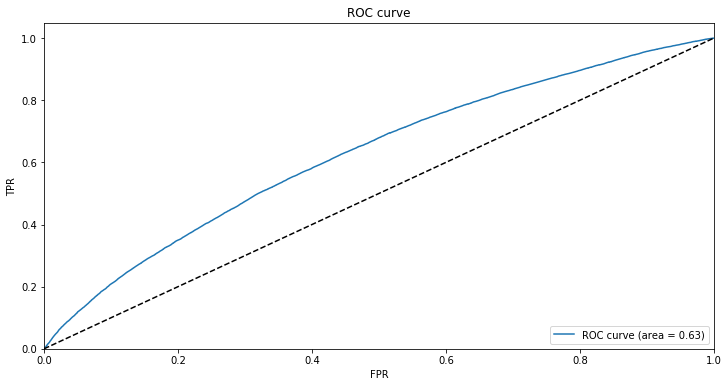

Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


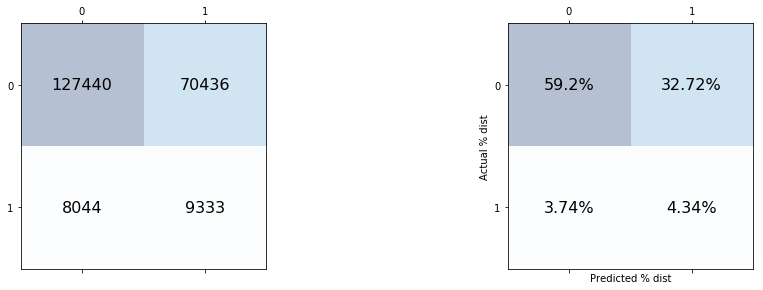


Total elapsed time:6.7s


In [38]:
tick=time.time()
#---------------------
# Logistic regression
#---------------------
clf_lr=linear_model.LogisticRegression(C=1, random_state=1234)

clf_lr_fit=clf_lr.fit(X_trn
                     ,y_trn)

y_trn_pred_lr=clf_lr_fit.predict_proba(X_trn)[:,1]

y_trn_predict_lr=clf_lr_fit.predict(X_trn)
y_trn_predict_lr=np.where(y_trn_pred_lr>0.09
                  ,1
                  ,0)


# Cross validation of model
cv_score_lr= cross_val_score(clf_lr_fit
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                        ,n_jobs=-1)

print("Cross validation performance: %0.3f (+/- %0.3f)" % (cv_score_lr.mean(), cv_score_lr.std() * 2))
print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_lr))

spr.f_roc_curve(y_trn, y_trn_pred_lr)
spr.f_conf_mtrx(True, y_trn, y_trn_predict_lr)

print ("\nTotal elapsed time:{}s".format(round(time.time()-tick, 2)))

Cross validation performance: 0.626 (+/- 0.010)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.95      0.57      0.71    197876
        1.0       0.11      0.64      0.19     17377

avg / total       0.88      0.57      0.67    215253

Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

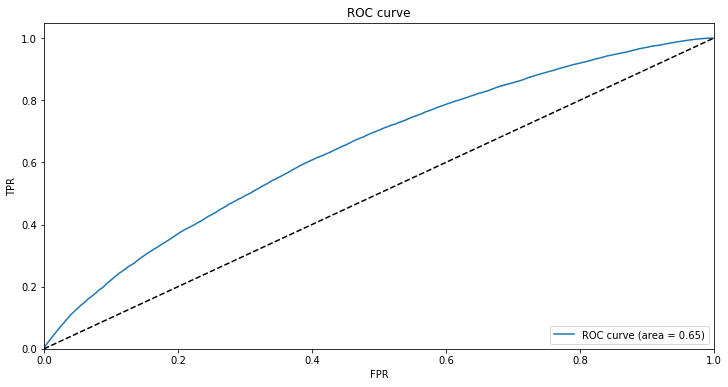

Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


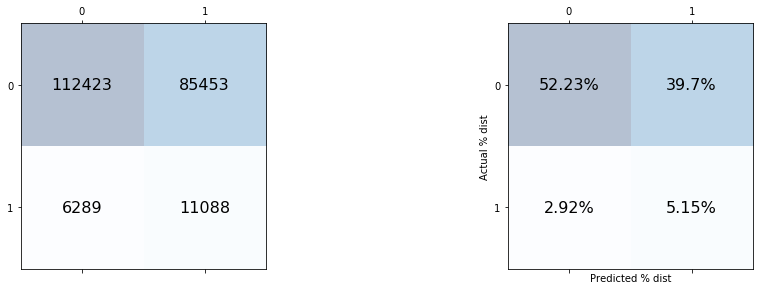


Total elapsed time is: 250s


In [39]:
tick=time.time()

#---------------------
# Random Forest
#---------------------
clf_rf=RandomForestClassifier(n_estimators=450, max_depth=8, min_samples_leaf=4,class_weight='balanced')
# clf_rf=RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_split=4, random_state=1234)
clr_rf_fit=clf_rf.fit(X_trn
                 ,y_trn)

y_trn_pred_rf=clr_rf_fit.predict_proba(X_trn)[:,1]

y_trn_predict_rf=clf_rf.predict(X_trn)
# y_trn_predict_rf=np.where(y_trn_pred_rf>0.08
#                      ,1
#                      ,0)

# Cross validation of model
cv_score_rf= cross_val_score(clf_rf
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=5
                        ,n_jobs=-1)

print("Cross validation performance: %0.3f (+/- %0.3f)" % (cv_score_rf.mean(), cv_score_rf.std() * 2))
print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_rf))

spr.f_roc_curve(y_trn, y_trn_pred_rf)
spr.f_conf_mtrx(True, y_trn, y_trn_predict_rf)

print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

In [40]:
def GS_Output_XGB(return_param):
    
    """
    Return GridSearch result from dictionary parameter search according to
        dict_param_xgb={'n_estimators':[100, 200, 300, 400], 'max_depth':[2,4,6,8], 'learning_rate':[0.0001,0.001,0.01,0.1],'objective':['binary:logistic']}
        
    The search was done on WoE categorical data with added continious featurs: income, annuity and credit amount.  
    """
    
    if return_param:
        dict_xgb_opt_param={'learning_rate': 0.1,
                             'max_depth': 4,
                             'n_estimators': 400,
                             'objective': 'binary:logistic'}                     
        
        return dict_xgb_opt_param
    else:
        print ("Returning None, ending.....")
        return None

C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cross validation performance TRAIN: 0.691 (+/- 0.004)
Cross validation performance VALIDATION: 0.622 (+/- 0.011)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96    197876
        1.0       0.95      0.00      0.00     17377

avg / total       0.92      0.92      0.88    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     84804
        1.0       0.17      0.00      0.00      7448

avg / total       0.86      0.92      0.88     92252

ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Figure size 432x288 with 0 Axes>

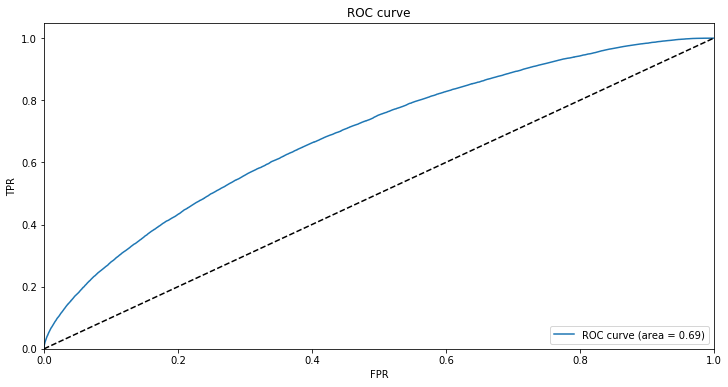

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

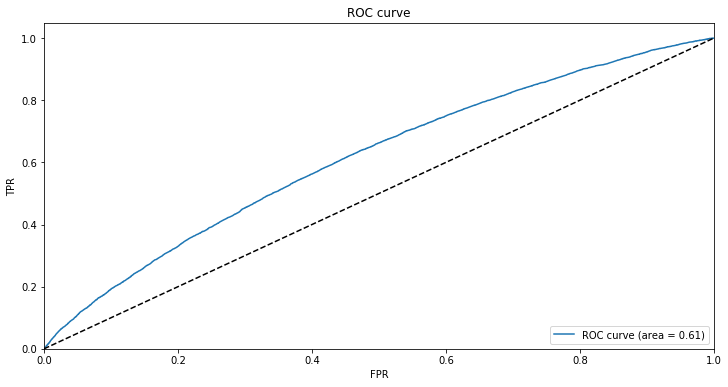

Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


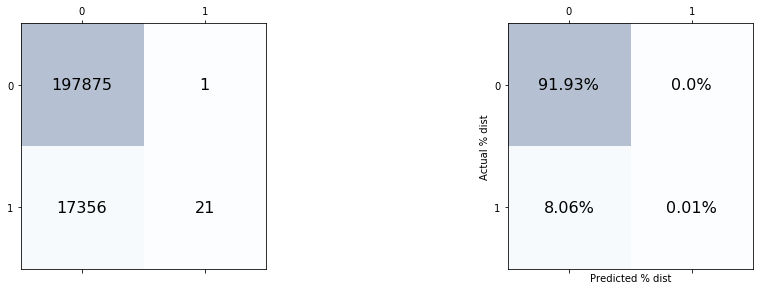

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


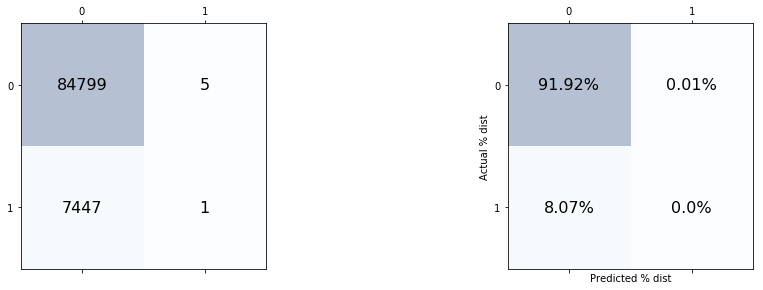


Total elapsed time is: 103s


In [41]:
tick=time.time()
#---------------------
# xgboost
#---------------------
clf_xgb_v1=xgbst.XGBClassifier(n_estimators=100, max_depth=8, min_samples_leaf=4, objective='binary:logistic')

clf_xgb_v1_fit=clf_xgb_v1.fit(X_trn
                            ,y_trn)

y_trn_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_trn)[:,1]
y_trn_predict_xgb_v1=clf_xgb_v1.predict(X_trn)

y_valid_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_valid)[:,1]
y_valid_predict_xgb_v1=clf_xgb_v1.predict(X_valid)


# Cross validation of model
cv_xgb_v1= cross_validate(clf_xgb_v1
                            ,X_trn
                            ,y_trn
                            ,scoring='roc_auc'
                            ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                            ,n_jobs=-1)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))

print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1))

print ("ROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("Confusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1)


print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

Cross validation performance TRAIN: 0.691 (+/- 0.004)
Cross validation performance VALIDATION: 0.622 (+/- 0.011)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.96      0.49      0.65    197876
        1.0       0.12      0.76      0.20     17377

avg / total       0.89      0.51      0.61    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.94      0.48      0.64     84804
        1.0       0.10      0.68      0.18      7448

avg / total       0.88      0.50      0.60     92252


ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Figure size 432x288 with 0 Axes>

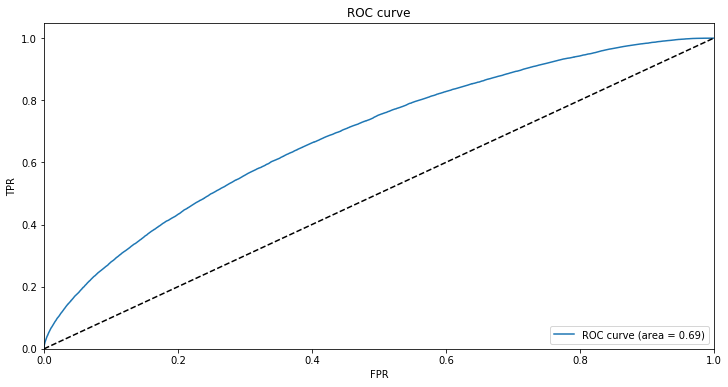

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

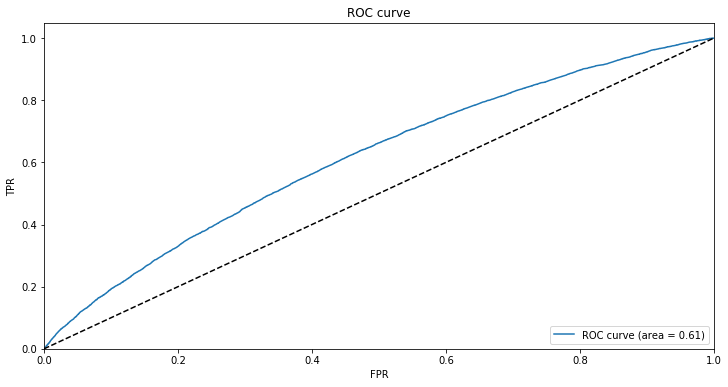


Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


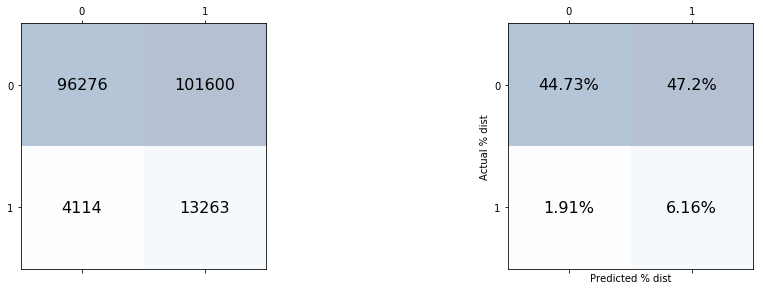

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


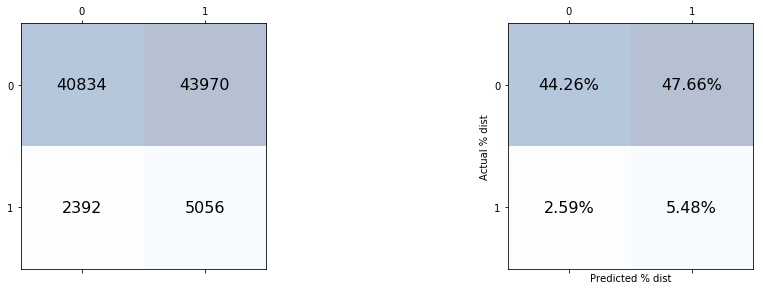

In [42]:
#-----------------------
# Customized cut-off
#-----------------------
y_trn_predict_xgb_v1_tune=np.where(y_trn_pred_xgb_v1>0.07
                                 ,1
                                 ,0)
y_valid_predict_xgb_v1_tune=np.where(y_valid_pred_xgb_v1>0.07
                                     ,1
                                     ,0)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))


print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1_tune))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1_tune))

print ("\nROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("\nConfusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1_tune)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1_tune)


plt.show()

-------
## 3. Discrete integer

1. Add further data sources! 
    * This is the most important step and will increase the possibility for the algorithm to split the data and discriminate adverse payment behavior even further
2. Do feature engineering on full data. 
    * This will further create valuable input for the model to use when setting parameters, also re-resting on choice done for categorical variables
2. Do a deep parameter search 
    * This to find the best settings, given available data. Given a good cross-validation outcome this will ensure that an optimal model is being used

### 3.1 Categorical data overview, missing values + IMpute

In [43]:
tick=time.time()

# Create overview of discrete integer columns
df_overv_disc_int, df_overv_obj=cstr.f_table_overv(True, df_trf_application_sub[list_col_int+['name_family_status']], ['None'], sclr_disc_cutoff=100)

# Add control metadata
def f_meta_df_over_disc_int(exec_f, indata, indata_main):
    if exec_f:
        df_temp_meta=indata.copy()
        df_temp=indata_main.copy()
        
        #-----------------
        # Rename columns
        #-----------------
        
        # All flag and binary
        bool_rename_flag=(df_temp_meta['col_name'].str.find('flag_')>=0)
        df_temp_meta.loc[bool_rename_flag, 'col_rename']=df_temp_meta['col_name'].str.replace('flag_', 'inp_f_').str.replace('document', 'doc')

        # All not flag and binary
        bool_rename_binary=(df_temp_meta['unq_val_cnt']==2) & (df_temp_meta['col_rename'].isna())
        df_temp_meta.loc[bool_rename_binary, 'col_rename']='inp_f_'+df_temp_meta['col_name'].astype('str')

        # All other columns
        bool_other=(df_temp_meta['col_rename'].isna())
        df_temp_meta.loc[bool_other, 'col_rename']='inp_grp_'+df_temp_meta['col_name'].astype('str')        
        
        #---------------------
        # Sort order columns
        #---------------------
        df_temp_meta=df_temp_meta[['col_name', 'col_rename']+[col for col in df_temp_meta.columns if col not in (['col_name', 'col_rename'])]]
        
        #--------------------------------------------------------
        # Binary column distribution in target, for drop columns
        #--------------------------------------------------------
        list_hld_flg_count=list()

        # Itterate through columns and aggregate
        for idx_flg_cnt, col_flg_cnt in enumerate(df_temp_meta[df_temp_meta['unq_val_cnt']==2]['col_name'].tolist()):

            df_agg_temp=df_temp[['sk_id_curr', col_flg_cnt]].groupby([col_flg_cnt]).count().T
            df_agg_temp['col_name_trg_cnt']=col_flg_cnt

            list_hld_flg_count.append(df_agg_temp)

        # Common agg table, per column, given target dist
        df_agg_flg_int_temp=pd.concat(list_hld_flg_count, axis=0, sort=True).reset_index(drop=True)
        df_agg_flg_int_temp=df_agg_flg_int_temp[['col_name_trg_cnt', 1, 0]]

        # Re-merge
        df_temp_meta=df_temp_meta.merge(df_agg_flg_int_temp, how='left', left_on='col_name', right_on='col_name_trg_cnt').drop('col_name_trg_cnt', axis=1)

        # Set drop column
        df_temp_meta['f_drop_col']=np.where(df_temp_meta[[1,0]].min(axis=1)<200 
                                      ,1
                                      ,0)
        
        # Add region_rating_client to drop_col since it has the lowest IV of the two region variables
        df_temp_meta['f_drop_col']=np.where(df_temp_meta['col_rename']=='inp_grp_region_rating_client'
                                      ,1
                                      ,df_temp_meta['f_drop_col'])
        
        # Return
        return df_temp_meta
        
    else:
        print ("No metadata changes to metadata overview table for discrete integer columns, ending...")
        return indata

df_overv_disc_int=f_meta_df_over_disc_int(True, df_overv_disc_int, df_trf_application_sub)

print ("Total elapsed time: {}s".format(round(time.time()-tick,2)))

df_overv_disc_int

Columns float: []
Columns int: ['cnt_children', 'days_birth', 'days_employed', 'days_id_publish', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'region_rating_client', 'region_rating_client_w_city', 'hour_appr_process_start', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'flag_document_2', 'flag_document_3', 'flag_document_4', 'flag_document_5', 'flag_document_6', 'flag_document_7', 'flag_document_8', 'flag_document_9', 'flag_document_10', 'flag_document_11', 'flag_document_12', 'flag_document_13', 'flag_document_14', 'flag_document_15', 'flag_document_16', 'flag_document_17', 'flag_document_18', 'flag_document_19', 'flag_document_20', 'flag_document_21']

All numerical columns: ['cnt_children', 'days_birth', 'days_employed', 'days_id_publish', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile

,col_name,col_rename,col_type,isnull_cnt,unq_val_cnt,n_rows_tot,%_null_tot,mean,std,min,25%,50%,75%,max,1,0,f_drop_col
0,cnt_children,inp_grp_cnt_children,int64,0,15,307505,0.0,0.417050,0.722120,0.0,0.0,0.0,1.0,19.0,NaN,NaN,0
1,days_birth,inp_grp_days_birth,int64,0,17460,307505,0.0,-16037.049495,4363.987877,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0,NaN,NaN,0
2,days_employed,inp_grp_days_employed,int64,0,12574,307505,0.0,63816.348794,141276.836143,-17912.0,-2760.0,-1213.0,-289.0,365243.0,NaN,NaN,0
3,days_id_publish,inp_grp_days_id_publish,int64,0,6168,307505,0.0,-2994.201437,1509.454886,-7197.0,-4299.0,-3254.0,-1720.0,0.0,NaN,NaN,0
4,flag_mobil,inp_f_mobil,int64,0,2,307505,0.0,0.999997,0.001803,0.0,1.0,1.0,1.0,1.0,307504.0,1.0,1
5,flag_emp_phone,inp_f_emp_phone,int64,0,2,307505,0.0,0.819886,0.384283,0.0,1.0,1.0,1.0,1.0,252119.0,55386.0,0
6,flag_work_phone,inp_f_work_phone,int64,0,2,307505,0.0,0.199356,0.399517,0.0,0.0,0.0,0.0,1.0,61303.0,246202.0,0
7,flag_cont_mobile,inp_f_cont_mobile,int64,0,2,307505,0.0,0.998133,0.043164,0.0,1.0,1.0,1.0,1.0,306931.0,574.0,0
8,flag_phone,inp_f_phone,int64,0,2,307505,0.0,0.281056,0.449515,0.0,0.0,0.0,1.0,1.0,86426.0,221079.0,0
9,flag_email,inp_f_email,int64,0,2,307505,0.0,0.056721,0.231309,0.0,0.0,0.0,0.0,1.0,17442.0,290063.0,0


### 3.2 Discrete integer feature visualization

C:\Users\patblo\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


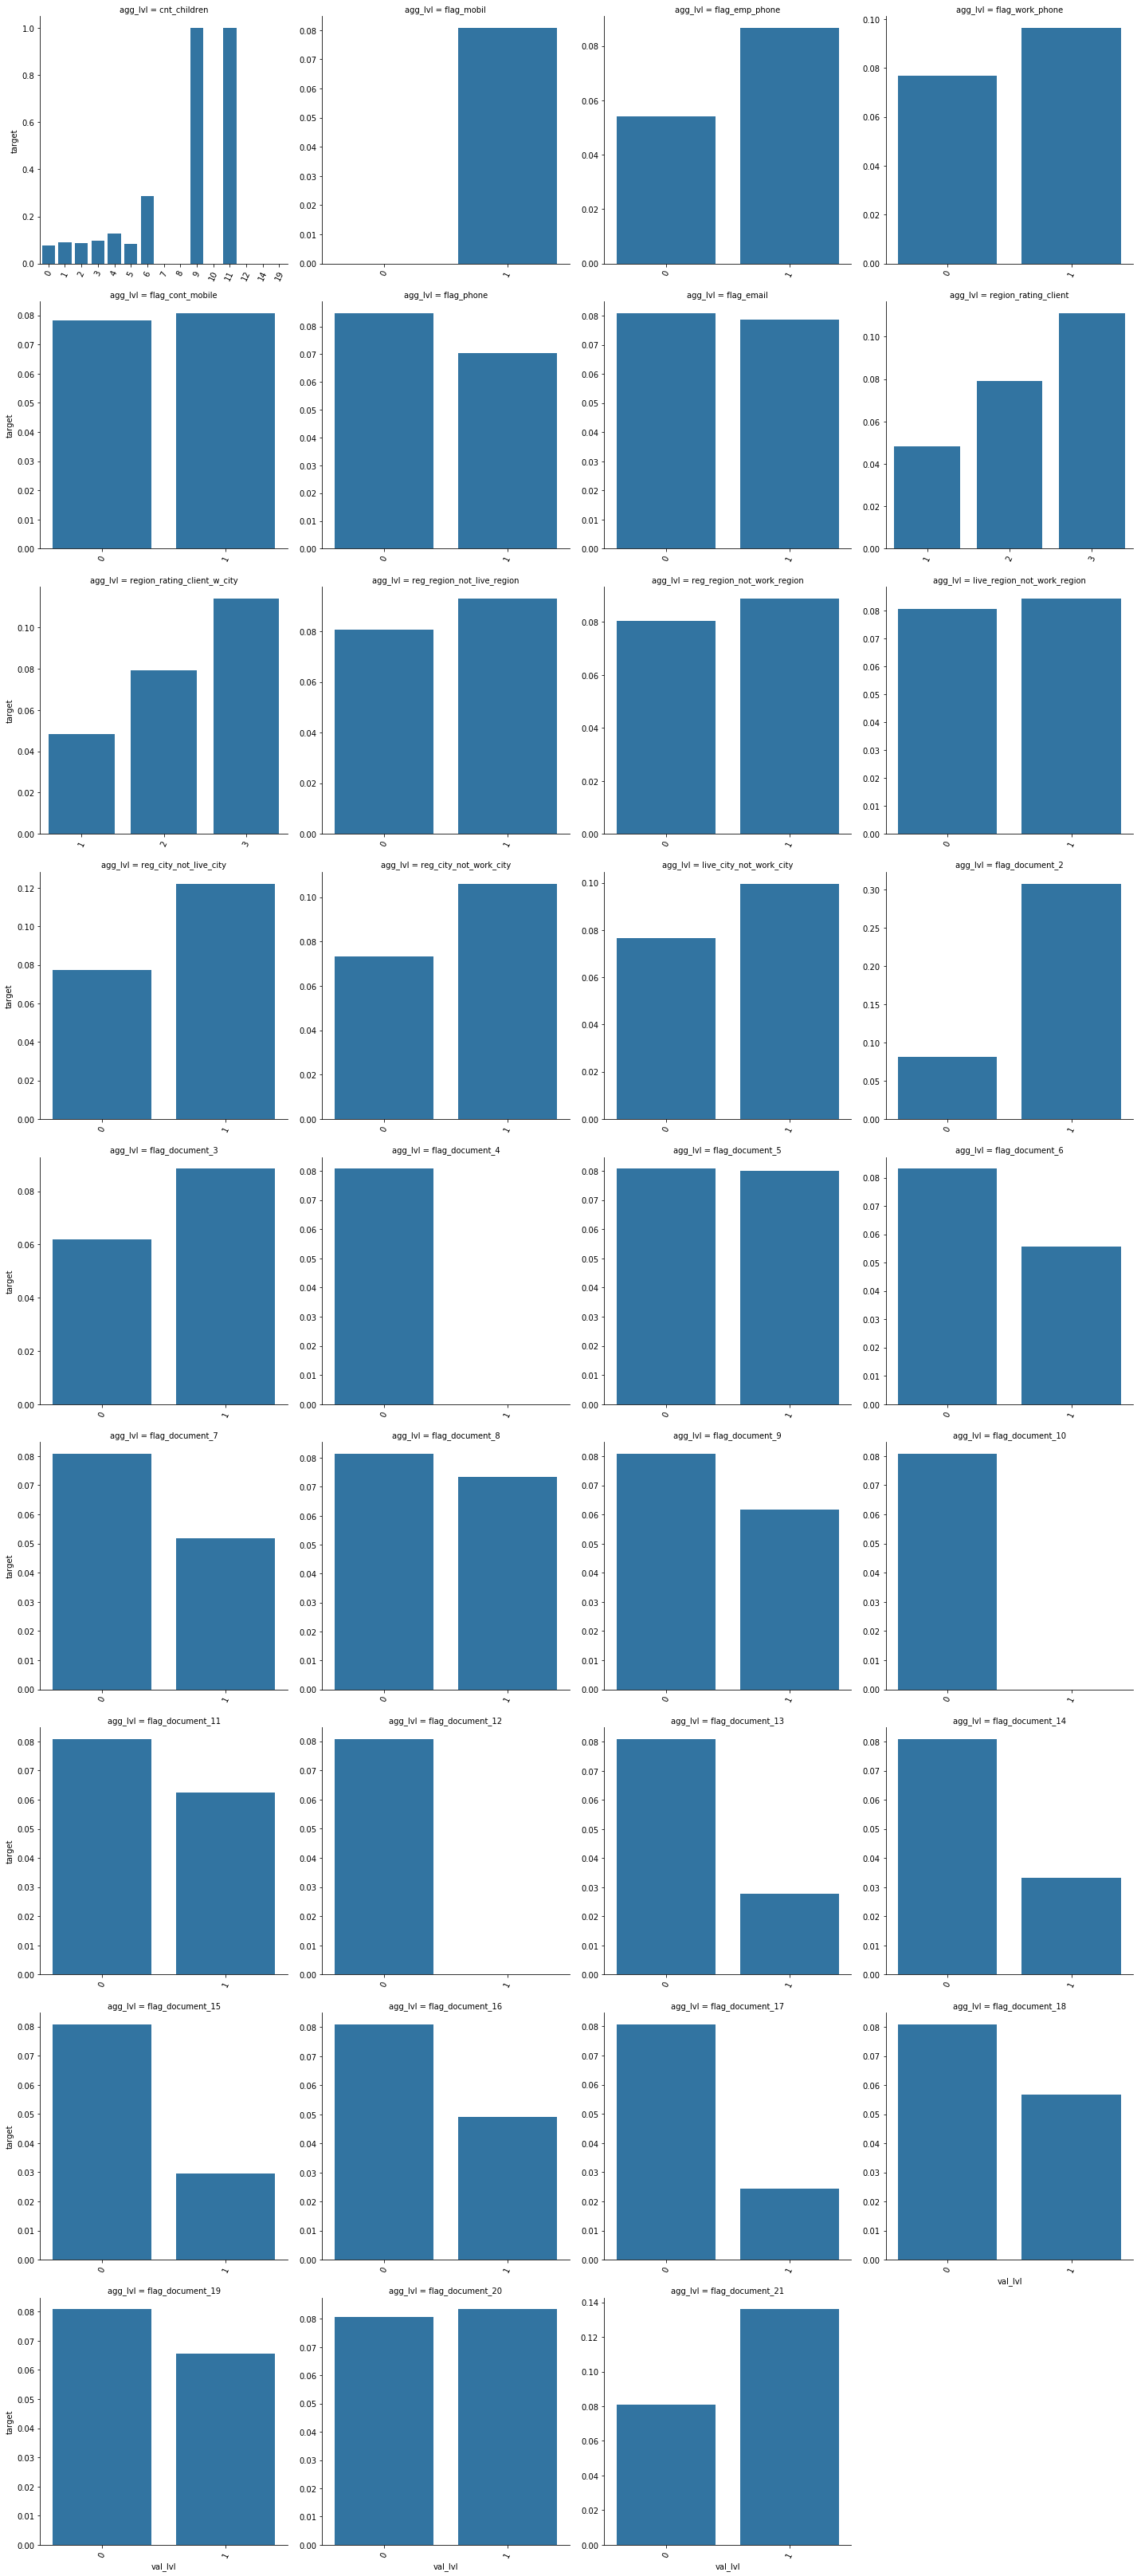

In [44]:
# Hold modified data
list_hld_grpby=list()

list_col_int_grpby=[col_name for col_name in list_col_int if len(pd.unique(df_trf_application_sub[col_name])) <=15]

# Work through all discrete columns and calculate mean of target (Basically go from "wide" to "long")
for grp_col in list_col_int_grpby:
    df_agg_tmp_int=df_trf_application_sub[['target']+[grp_col]].groupby([grp_col],as_index=False).mean()
    df_agg_tmp_int.rename(columns={grp_col:'val_lvl'}, inplace=True)
    df_agg_tmp_int['agg_lvl']=grp_col

    # Add to holder
    list_hld_grpby.append(df_agg_tmp_int)

# Combine to common
df_mlt_agg_int=pd.concat(list_hld_grpby,sort=True)

# Initialize grid, and fill with individual barplot objects
h=sns.FacetGrid(df_mlt_agg_int, col='agg_lvl', col_wrap=4, sharex=False, sharey=False, height=5)
h.map(sns.barplot, 'val_lvl','target')

# Rotate ticks so high freq discrete x-axis values dont overlap
for ax in h.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

# Tight layout and show()
plt.tight_layout()
plt.show()

### 3.3 Discrete feature table overview

In [45]:
# We add back organization type since the nr unique levels isnt a problem here
list_col_tmp_day=[day for day in list_col_int if day.find('days')>=0]
list_col_tmp_hour=['hour_appr_process_start']

f_discr_tbl_agg(True, df_trf_application_sub, list_col_int_grpby+list_col_tmp_hour)

Total rows is: 307505, overall bad rate is: 8.073%

Colum being analyzed is: cnt_children


cnt_children  target                  %_count_of_total
                  count    sum      mean                 
0             0  215367  16609  0.077120         0.700369
1             1   61118   5454  0.089237         0.198754
2             2   26748   2333  0.087221         0.086984
3             3    3717    358  0.096314         0.012088
4             4     429     55  0.128205         0.001395
5             5      84      7  0.083333         0.000273
6             6      21      6  0.285714         0.000068
7             7       7      0  0.000000         0.000023
8             8       2      0  0.000000         0.000007
9             9       2      2  1.000000         0.000007
10           10       2      0  0.000000         0.000007
11           11       1      1  1.000000         0.000003
12           12       2      0  0.000000         0.000007
13           14       3      0  0.000000         0.000010
14           19       2      0  0.000000         0.000007


Colum being analyzed is: flag_mobil


flag_mobil  target                  %_count_of_total
               count    sum      mean                 
0          0       1      0  0.000000         0.000003
1          1  307504  24825  0.080731         0.999997


Colum being analyzed is: flag_emp_phone


flag_emp_phone  target                  %_count_of_total
                   count    sum      mean                 
0              0   55386   2991  0.054003         0.180114
1              1  252119  21834  0.086602         0.819886


Colum being analyzed is: flag_work_phone


flag_work_phone  target                  %_count_of_total
                    count    sum      mean                 
0               0  246202  18921  0.076852         0.800644
1               1   61303   5904  0.096309         0.199356


Colum being analyzed is: flag_cont_mobile


flag_cont_mobile  target                  %_count_of_total
                     count    sum      mean                 
0                0     574     45  0.078397         0.001867
1                1  306931  24780  0.080735         0.998133


Colum being analyzed is: flag_phone


flag_phone  target                  %_count_of_total
               count    sum      mean                 
0          0  221079  18744  0.084784         0.718944
1          1   86426   6081  0.070361         0.281056


Colum being analyzed is: flag_email


flag_email  target                  %_count_of_total
               count    sum      mean                 
0          0  290063  23451  0.080848         0.943279
1          1   17442   1374  0.078775         0.056721


Colum being analyzed is: region_rating_client


region_rating_client  target                  %_count_of_total
                         count    sum      mean                 
0                    1   32197   1552  0.048203         0.104704
1                    2  226979  17907  0.078893         0.738131
2                    3   48329   5366  0.111031         0.157165


Colum being analyzed is: region_rating_client_w_city


region_rating_client_w_city  target                  %_count_of_total
                                count    sum      mean                 
0                           1   34167   1654  0.048409         0.111110
1                           2  229479  18170  0.079179         0.746261
2                           3   43859   5001  0.114024         0.142629


Colum being analyzed is: reg_region_not_live_region


reg_region_not_live_region  target                  %_count_of_total
                               count    sum      mean                 
0                          0  302848  24392  0.080542         0.984856
1                          1    4657    433  0.092978         0.015144


Colum being analyzed is: reg_region_not_work_region


reg_region_not_work_region  target                  %_count_of_total
                               count    sum      mean                 
0                          0  291894  23437  0.080293         0.949233
1                          1   15611   1388  0.088912         0.050767


Colum being analyzed is: live_region_not_work_region


live_region_not_work_region  target                  %_count_of_total
                                count    sum      mean                 
0                           0  295003  23769  0.080572         0.959344
1                           1   12502   1056  0.084466         0.040656


Colum being analyzed is: reg_city_not_live_city


reg_city_not_live_city  target                  %_count_of_total
                           count    sum      mean                 
0                      0  283466  21886  0.077209         0.921826
1                      1   24039   2939  0.122260         0.078174


Colum being analyzed is: reg_city_not_work_city


reg_city_not_work_city  target                  %_count_of_total
                           count    sum      mean                 
0                      0  236639  17305  0.073128         0.769545
1                      1   70866   7520  0.106116         0.230455


Colum being analyzed is: live_city_not_work_city


live_city_not_work_city  target                  %_count_of_total
                            count    sum      mean                 
0                       0  252291  19322  0.076586         0.820445
1                       1   55214   5503  0.099667         0.179555


Colum being analyzed is: flag_document_2


flag_document_2  target                  %_count_of_total
                    count    sum      mean                 
0               0  307492  24821  0.080721         0.999958
1               1      13      4  0.307692         0.000042


Colum being analyzed is: flag_document_3


flag_document_3  target                  %_count_of_total
                    count    sum      mean                 
0               0   89165   5513  0.061829         0.289963
1               1  218340  19312  0.088449         0.710037


Colum being analyzed is: flag_document_4


flag_document_4  target                  %_count_of_total
                    count    sum      mean                 
0               0  307480  24825  0.080737         0.999919
1               1      25      0  0.000000         0.000081


Colum being analyzed is: flag_document_5


flag_document_5  target                  %_count_of_total
                    count    sum      mean                 
0               0  302858  24453  0.080741         0.984888
1               1    4647    372  0.080052         0.015112


Colum being analyzed is: flag_document_6


flag_document_6  target                  %_count_of_total
                    count    sum      mean                 
0               0  280427  23318  0.083152         0.911943
1               1   27078   1507  0.055654         0.088057


Colum being analyzed is: flag_document_7


flag_document_7  target                  %_count_of_total
                    count    sum      mean                 
0               0  307447  24822  0.080736         0.999811
1               1      58      3  0.051724         0.000189


Colum being analyzed is: flag_document_8


flag_document_8  target                  %_count_of_total
                    count    sum      mean                 
0               0  282481  22989  0.081382         0.918622
1               1   25024   1836  0.073370         0.081378


Colum being analyzed is: flag_document_9


flag_document_9  target                  %_count_of_total
                    count    sum      mean                 
0               0  306307  24751  0.080805         0.996104
1               1    1198     74  0.061770         0.003896


Colum being analyzed is: flag_document_10


flag_document_10  target                  %_count_of_total
                     count    sum      mean                 
0                0  307498  24825  0.080732         0.999977
1                1       7      0  0.000000         0.000023


Colum being analyzed is: flag_document_11


flag_document_11  target                  %_count_of_total
                     count    sum      mean                 
0                0  306302  24750  0.080803         0.996088
1                1    1203     75  0.062344         0.003912


Colum being analyzed is: flag_document_12


flag_document_12  target                  %_count_of_total
                     count    sum      mean                 
0                0  307503  24825  0.080731         0.999993
1                1       2      0  0.000000         0.000007


Colum being analyzed is: flag_document_13


flag_document_13  target                  %_count_of_total
                     count    sum      mean                 
0                0  306421  24795  0.080918         0.996475
1                1    1084     30  0.027675         0.003525


Colum being analyzed is: flag_document_14


flag_document_14  target                  %_count_of_total
                     count    sum      mean                 
0                0  306602  24795  0.080870         0.997063
1                1     903     30  0.033223         0.002937


Colum being analyzed is: flag_document_15


flag_document_15  target                  %_count_of_total
                     count    sum      mean                 
0                0  307133  24814  0.080792          0.99879
1                1     372     11  0.029570          0.00121


Colum being analyzed is: flag_document_16


flag_document_16  target                  %_count_of_total
                     count    sum      mean                 
0                0  304452  24675  0.081047         0.990072
1                1    3053    150  0.049132         0.009928


Colum being analyzed is: flag_document_17


flag_document_17  target                  %_count_of_total
                     count    sum      mean                 
0                0  307423  24823  0.080745         0.999733
1                1      82      2  0.024390         0.000267


Colum being analyzed is: flag_document_18


flag_document_18  target                  %_count_of_total
                     count    sum      mean                 
0                0  305005  24683  0.080927          0.99187
1                1    2500    142  0.056800          0.00813


Colum being analyzed is: flag_document_19


flag_document_19  target                  %_count_of_total
                     count    sum      mean                 
0                0  307322  24813  0.080739         0.999405
1                1     183     12  0.065574         0.000595


Colum being analyzed is: flag_document_20


flag_document_20  target                  %_count_of_total
                     count    sum      mean                 
0                0  307349  24812  0.080729         0.999493
1                1     156     13  0.083333         0.000507


Colum being analyzed is: flag_document_21


flag_document_21  target                  %_count_of_total
                     count    sum      mean                 
0                0  307402  24811  0.080712         0.999665
1                1     103     14  0.135922         0.000335


Colum being analyzed is: hour_appr_process_start


hour_appr_process_start target                 %_count_of_total
                            count   sum      mean                 
0                        0     40     6  0.150000         0.000130
1                        1     86     7  0.081395         0.000280
2                        2    305    30  0.098361         0.000992
3                        3   1230   107  0.086992         0.004000
4                        4   2090   173  0.082775         0.006797
5                        5   3638   385  0.105827         0.011831
6                        6   5842   645  0.110407         0.018998
7                        7   9131   917  0.100427         0.029694
8                        8  15127  1373  0.090765         0.049193
9                        9  27384  2247  0.082055         0.089052
10                      10  37721  3026  0.080221         0.122668
11                      11  37229  3006  0.080744         0.121068
12                      12  34233  2827  0.082581         0.111325
13                      13  30959  2485  0.080267         0.100678
14                      14  27681  2189  0.079080         0.090018
15                      15  24836  1886  0.075938         0.080766
16                      16  20384  1521  0.074617         0.066288
17                      17  14900   967  0.064899         0.048454
18                      18   9049   635  0.070173         0.029427
19                      19   3848   264  0.068607         0.012514
20                      20   1196    84  0.070234         0.003889
21                      21    405    25  0.061728         0.001317
22                      22    150    15  0.100000         0.000488
23                      23     41     5  0.121951         0.000133

### 3.4 Transform categorical integer columns

1. *cnt_children* 
 * If >= 3 children --> 'ge 3'.
<br><br>
2. *hour_appr_process_start*
 * Bin it in 8 equaly sized bins.
<br><br>
3. *region_rating_client* and *region_rating_client_w_city*
 * Drop *region_rating_client* since it has the lowes IV of the two
 <br><br>
4. All columns from *df_overv_disc_int* with binary freq
 * if *flag_document* --> Rename: *inp_f_doc...*
 * if simply binary --> prefix *inp_f*
 * if to low nr unique then drop accoring to heuristic
<br><br>
5. *days_birth*, *days_employed* and *day_id_published*
 * Bin into 10 equal groups and WoE

In [46]:
def f_trf_application_int(exec_f, indata, indata_meta):
    
    if exec_f:
        df_temp=indata.copy()
        df_temp_meta=indata_meta.copy()
    
        #--------------------------
        # Drop stuff we dont need
        #--------------------------
        list_col_drop=df_temp_meta[df_temp_meta['f_drop_col']==1]['col_name'].tolist()
        list_col_drop=list_col_drop+['region_rating_client']
        
        print ("Droping the following columns:")
        print (list_col_drop)
        # Also drop region_rating_client since it has the lowest IV of the two "region" features
        df_temp.drop(list_col_drop, inplace=True, axis=1)
    
        #------------------
        # cnt_children
        #------------------
        df_temp['inp_grp_cnt_children']=np.where(df_temp['cnt_children']>=3
                                        ,3
                                        ,df_temp['cnt_children'])

        #-------------------------
        # hour_app_process_start
        #------------------------
        df_temp['inp_grp_hour_appr_process_start']=pd.qcut(df_temp['hour_appr_process_start'], 8)
        df_temp['inp_grp_hour_appr_process_start']=df_temp['inp_grp_hour_appr_process_start'].cat.codes+1

        #-----------------------------------------------
        # Rename columns with 'flag_doc' prefix and 
        # columns with nr unique levels=2 --> 'inp_f_'
        #----------------------------------------------
        df_temp.rename(columns=lambda i: i.replace('flag_document', 'inp_f_doc') if i.find('flag_document')>=0 else i, inplace=True)
        df_temp.rename(columns=lambda i: 'inp_f_'+i if i.find('_not_')>=0 else i, inplace=True)
        
        
        #------------------------------------
        # Bin the discrete 'days'-variables 
        # in meaningful groups
        #------------------------------------
        
        # Days birth
        df_temp['inp_grp_days_birth']=pd.qcut(df_temp['days_birth'], 10)
        df_temp['inp_grp_days_birth']=df_temp['inp_grp_days_birth'].cat.codes+1

        # Days employed 
        df_temp['inp_grp_days_employed']=pd.qcut(df_temp['days_employed'], 5, precision=5, duplicates='raise')
        df_temp['inp_grp_days_employed']=df_temp['inp_grp_days_employed'].cat.codes

        # days_id_published 
        df_temp['inp_grp_days_id_publish']=pd.qcut(df_temp['days_id_publish'], 10)
        df_temp['inp_grp_days_id_publish']=df_temp['inp_grp_days_id_publish'].cat.codes+1
        
        #-------------------------------
        # Rename all the flag columns
        #-------------------------------
        list_col_from=df_overv_disc_int[df_overv_disc_int['unq_val_cnt']==2]['col_name'].tolist()
        list_col_to=df_overv_disc_int[df_overv_disc_int['unq_val_cnt']==2]['col_rename'].tolist()
        
        dict_rename_col=dict(zip(list_col_from, list_col_to))
        
        # Manually add since other 'region'-feature was removed
        dict_rename_col.update({'region_rating_client_w_city':'inp_grp_region_rating_client_w_city'})
        
        # apply reanme
        df_temp.rename(columns=dict_rename_col, inplace=True)
        
        # return transformed data
        return df_temp
        
    else:
        print ("No transformatino of data, ending....")
        return indata

In [47]:
df_trf_applications_sub_v2=f_trf_application_int(True, df_trf_application_sub, df_overv_disc_int)

Droping the following columns:
['flag_mobil', 'region_rating_client', 'flag_document_2', 'flag_document_4', 'flag_document_7', 'flag_document_10', 'flag_document_12', 'flag_document_17', 'flag_document_19', 'flag_document_20', 'flag_document_21', 'region_rating_client']


### 3.5 WoE and IV

In [48]:
list_col_disc_int_woe=df_overv_disc_int[(df_overv_disc_int['col_rename'].str.find('inp_grp')>=0) & (df_overv_disc_int['f_drop_col']!=1)]['col_rename'].tolist()

# Estimate WoE
df_woe, df_iv=f_woe(True, df_trf_applications_sub_v2, list_col_disc_int_woe, {'sk_id_curr': 'count', 'target':['sum']})

# We take the WoE data, set it to a dictionary so we can recode our gategorical variables
dict_map_woe=f_dict_map_woe(True, df_woe, [col for col in df_trf_application_sub.columns if col.find('inp_grp')>=0])

Commencing calculation of WoE and IV for variable: inp_grp_cnt_children
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_cnt_children']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_days_birth
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_days_birth']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_days_employed
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_days_employed']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_days_id_publish
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_days_id_publish']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_region_rating_cli

### 3.6 Models
    * Logistic Regression
    * Random Forrest
    * XGBoost

In [49]:
X_trn=df_trf_applications_sub_v2[[flg for flg in df_trf_applications_sub_v2.columns if flg.find('inp_f')>=0]+[woe for woe in df_trf_applications_sub_v2.columns if woe.find('woe')>=0]].astype('float64').values
# X_trn=df_trf_application_sub[['inp_f_gender','inp_f_contract_type','inp_grp_name_housing_type_woe']].astype('float64').values
y=df_trf_application_sub['target'].astype('float64').values

In [50]:
X_trn, X_valid, y_trn, y_valid=train_test_split(X_trn
                                                ,y
                                                ,test_size=0.3
                                                ,random_state=1234
                                               ,stratify=y
                                               )


Cross validation performance: 0.638 (+/- 0.012)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.94      0.67      0.78    197876
        1.0       0.12      0.53      0.20     17377

avg / total       0.88      0.66      0.74    215253

Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

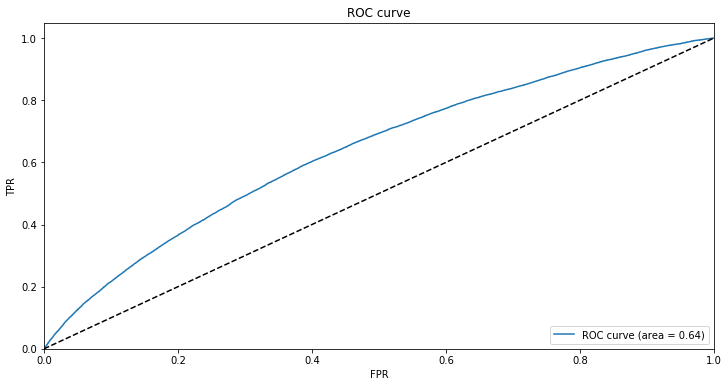

Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


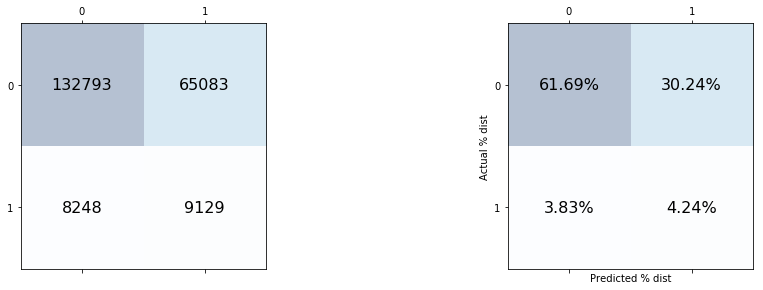


Total elapsed time:12.22s


In [51]:



tick=time.time()
#---------------------
# Logistic regression
#---------------------
clf_lr=linear_model.LogisticRegression(C=1, random_state=1234)

clf_lr_fit=clf_lr.fit(X_trn
                     ,y_trn)

y_trn_pred_lr=clf_lr_fit.predict_proba(X_trn)[:,1]

y_trn_predict_lr=clf_lr_fit.predict(X_trn)
y_trn_predict_lr=np.where(y_trn_pred_lr>0.09
                  ,1
                  ,0)


# Cross validation of model
cv_score_lr= cross_val_score(clf_lr_fit
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                        ,n_jobs=-1)

print("Cross validation performance: %0.3f (+/- %0.3f)" % (cv_score_lr.mean(), cv_score_lr.std() * 2))
print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_lr))

spr.f_roc_curve(y_trn, y_trn_pred_lr)
spr.f_conf_mtrx(True, y_trn, y_trn_predict_lr)

print ("\nTotal elapsed time:{}s".format(round(time.time()-tick, 2)))






Cross validation performance TRAIN: 0.655 (+/- 0.003)
Cross validation performance VALIDATION: 0.634 (+/- 0.012)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.95      0.58      0.72    197876
        1.0       0.12      0.63      0.20     17377

avg / total       0.88      0.59      0.68    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.94      0.59      0.72     84804
        1.0       0.11      0.60      0.19      7448

avg / total       0.88      0.59      0.68     92252

ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Figure size 432x288 with 0 Axes>

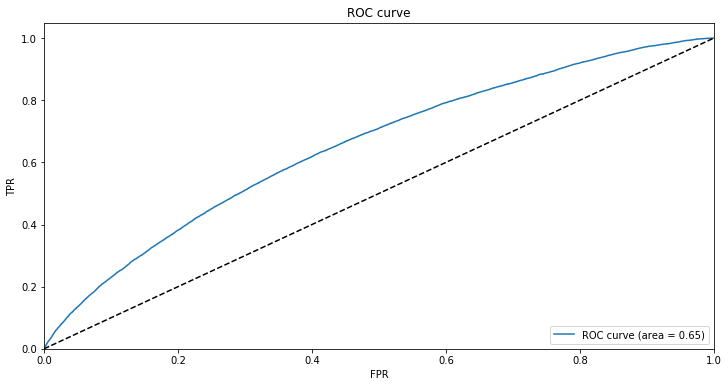

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

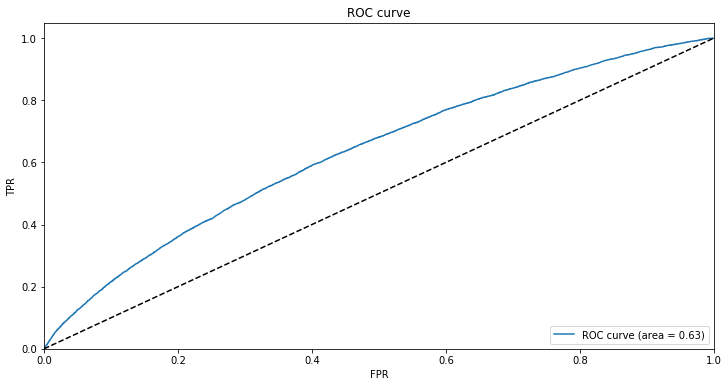

Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


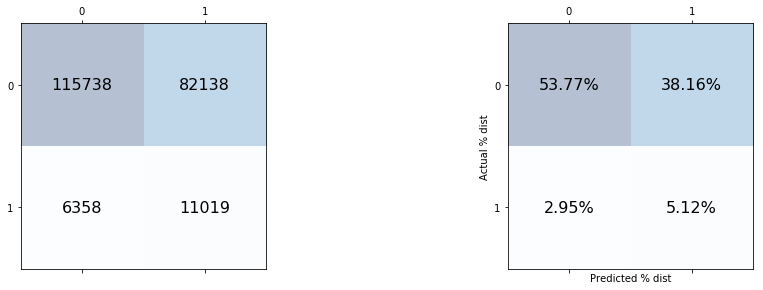

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


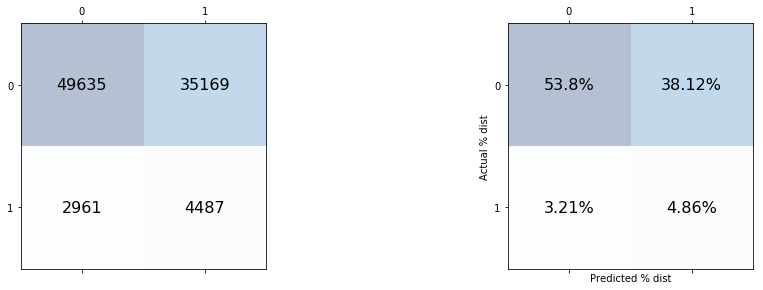


Total elapsed time is: 315s


In [52]:
tick=time.time()

#---------------------
# Random Forest
#---------------------
clf_rf=RandomForestClassifier(n_estimators=450, max_depth=8, min_samples_leaf=4,class_weight='balanced')
# clf_rf=RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_split=4, random_state=1234)
clr_rf_fit=clf_rf.fit(X_trn
                 ,y_trn)

y_trn_pred_rf=clr_rf_fit.predict_proba(X_trn)[:,1]
y_trn_predict_rf=clf_rf.predict(X_trn)

y_valid_pred_rf=clr_rf_fit.predict_proba(X_valid)[:,1]
y_valid_predict_rf=clf_rf.predict(X_valid)



# Cross validation of model
cv_rf= cross_validate(clf_rf
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=5
                        ,n_jobs=-1)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_rf['train_score'].mean(), cv_rf['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_rf['test_score'].mean(), cv_rf['test_score'].std()*2))

print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_rf))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_rf))

print ("ROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_rf)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_rf)

print ("Confusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_rf)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_rf)


print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cross validation performance TRAIN: 0.671 (+/- 0.002)
Cross validation performance VALIDATION: 0.638 (+/- 0.013)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96    197876
        1.0       0.83      0.00      0.00     17377

avg / total       0.91      0.92      0.88    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     84804
        1.0       0.67      0.00      0.00      7448

avg / total       0.90      0.92      0.88     92252

ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Figure size 432x288 with 0 Axes>

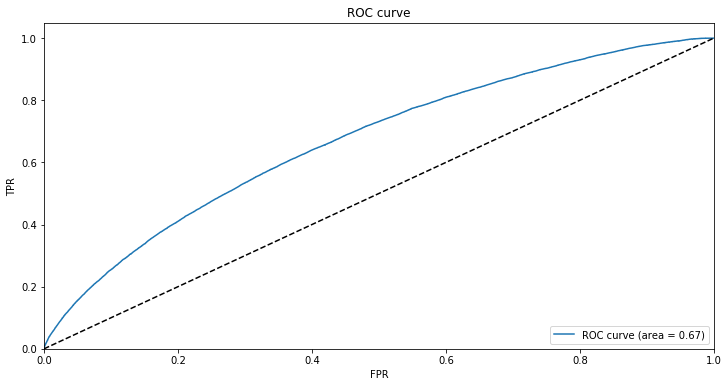

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

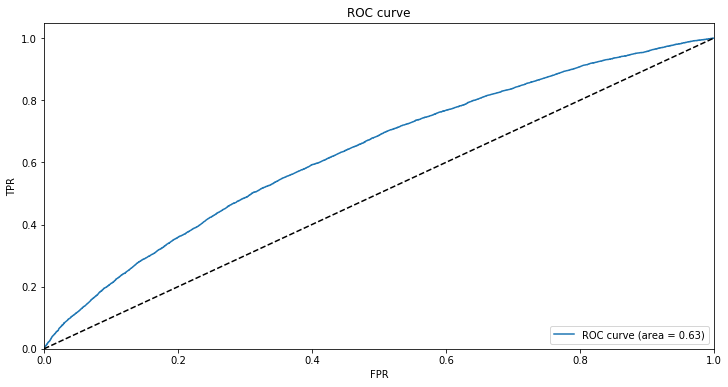

Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


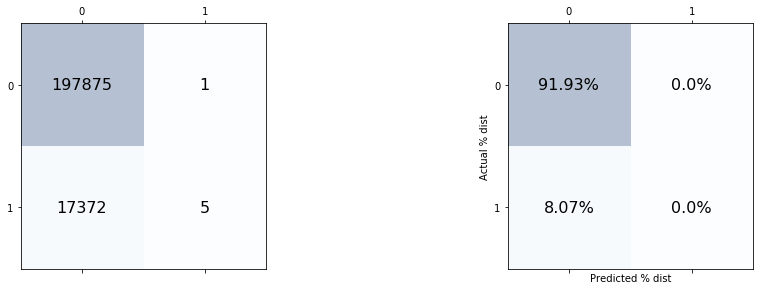

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


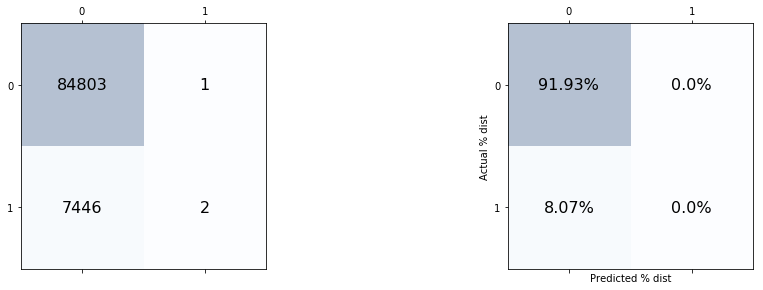


Total elapsed time is: 450s


In [53]:


tick=time.time()
#---------------------
# xgboost
#---------------------
clf_xgb_v1=xgbst.XGBClassifier(n_estimators=450, learning_rate=0.1,max_depth=4, objective='binary:logistic')

clf_xgb_v1_fit=clf_xgb_v1.fit(X_trn
                            ,y_trn)

y_trn_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_trn)[:,1]
y_trn_predict_xgb_v1=clf_xgb_v1.predict(X_trn)

y_valid_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_valid)[:,1]
y_valid_predict_xgb_v1=clf_xgb_v1.predict(X_valid)


# Cross validation of model
cv_xgb_v1= cross_validate(clf_xgb_v1
                            ,X_trn
                            ,y_trn
                            ,scoring='roc_auc'
                            ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                            ,n_jobs=-1)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))

print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1))

print ("ROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("Confusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1)


print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

Cross validation performance TRAIN: 0.671 (+/- 0.002)
Cross validation performance VALIDATION: 0.638 (+/- 0.013)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.96      0.39      0.55    197876
        1.0       0.10      0.82      0.19     17377

avg / total       0.89      0.42      0.52    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.95      0.39      0.55     84804
        1.0       0.10      0.78      0.18      7448

avg / total       0.88      0.42      0.52     92252


ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


<Figure size 432x288 with 0 Axes>

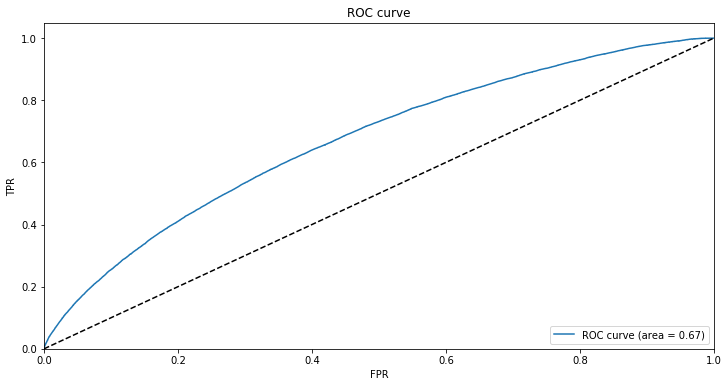

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

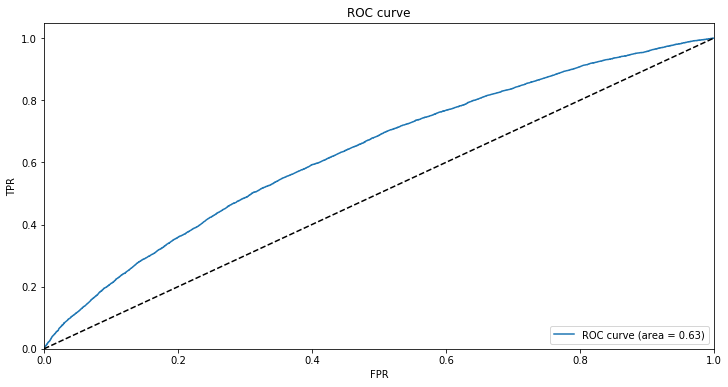


Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


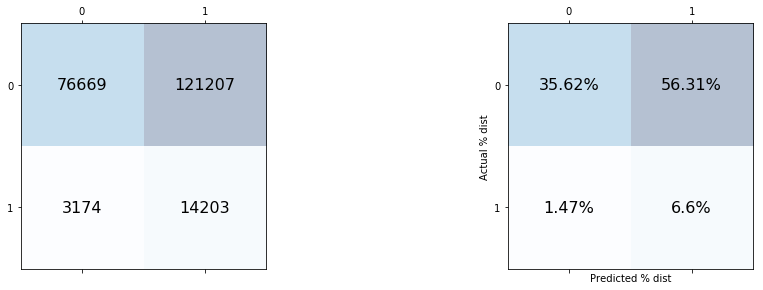

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


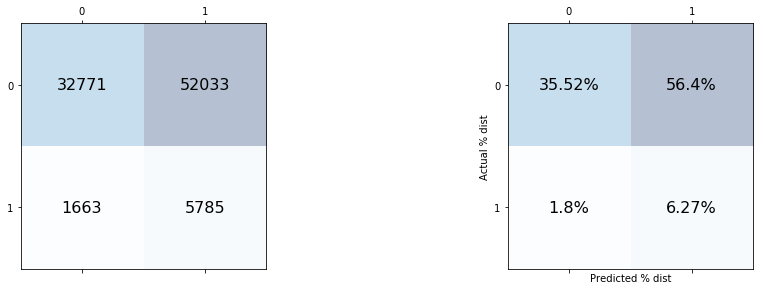

In [54]:
#-----------------------
# Customized cut-off
#-----------------------
y_trn_predict_xgb_v1_tune=np.where(y_trn_pred_xgb_v1>0.06
                                 ,1
                                 ,0)
y_valid_predict_xgb_v1_tune=np.where(y_valid_pred_xgb_v1>0.06
                                     ,1
                                     ,0)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))


print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1_tune))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1_tune))

print ("\nROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("\nConfusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1_tune)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1_tune)


plt.show()

-------
## 4. Continious features



### 4.1 Continious data overview
    * Outliers

In [55]:
tick=time.time()

# Create base overviee table
df_overv_cont, df_over_oth=cstr.f_table_overv(True, df_trf_applications_sub_v2[list_col_float+['name_contract_type']],['None'],sclr_disc_cutoff=100)

# Add control metadata
def f_meta_df_overv_float(exec_f, indata, indata_main):
    if exec_f:
        df_temp_meta=indata.copy()
        df_temp=indata_main.copy()
        
        #-----------------
        # Rename columns
        #-----------------
        df_temp_meta['col_rename']='inp_'+df_temp_meta['col_name'].astype('str')
            
        
        #------------------
        # impute strategy
        #------------------
        
        # Most frequently occuring value in discrete distribution
        list_col_max_val_disc=[col for col in df_temp_meta['col_name'].tolist() if col.find('amt_req_credit')>=0]+[col for col in df_temp_meta['col_name'].tolist() if col.find('social_circle')>=0]
        bool_imp_max_freq_cnt=(df_temp_meta['col_name'].isin(list_col_max_val_disc))
        
        # Mean or median value
        bool_imp_median_mean=(df_temp_meta['%_null_tot']>0) & (df_temp_meta['%_null_tot']<0.10) & (df_temp_meta['unq_val_cnt']>35)
        
        # Other impute (model, fall-back to median/mean, etc...) 
        bool_imp_other=(df_temp_meta['%_null_tot']>0.1) 
        
        # Create column given boolen expression
        df_temp_meta['col_imp_strg']=np.where(bool_imp_max_freq_cnt
                                             ,'MaxValDisc'
                                             ,np.where(bool_imp_median_mean
                                                       ,'Median/Mean'
                                                       ,np.where(bool_imp_other
                                                                 ,'Other'
                                                                 ,'NoNaN'
                                                                )
                                                      )
                                             )
        
        #---------------------
        # Sort order columns
        #---------------------
        df_temp_meta=df_temp_meta[['col_name', 'col_rename','col_imp_strg']+[col for col in df_temp_meta.columns if col not in (['col_name', 'col_rename','col_imp_strg'])]]
        
        
        #------------
        # Return
        #------------
        return df_temp_meta
        
    else:
        print ("No metadata changes to metadata overview table for discrete integer columns, ending...")
        return indata

# call function
df_overv_cont=f_meta_df_overv_float(True, df_overv_cont, df_trf_applications_sub_v2)

print ("Total elapsed time: {}s".format(round(time.time()-tick,2)))

df_overv_cont

Columns float: ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative', 'days_registration', 'own_car_age', 'cnt_fam_members', 'ext_source_1', 'ext_source_2', 'ext_source_3', 'obs_30_cnt_social_circle', 'def_30_cnt_social_circle', 'obs_60_cnt_social_circle', 'def_60_cnt_social_circle', 'days_last_phone_change', 'amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week', 'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt', 'amt_req_credit_bureau_year']
Columns int: []

All numerical columns: ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative', 'days_registration', 'own_car_age', 'cnt_fam_members', 'ext_source_1', 'ext_source_2', 'ext_source_3', 'obs_30_cnt_social_circle', 'def_30_cnt_social_circle', 'obs_60_cnt_social_circle', 'def_60_cnt_social_circle', 'days_last_phone_change', 'amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',

,col_name,col_rename,col_imp_strg,col_type,isnull_cnt,unq_val_cnt,n_rows_tot,%_null_tot,mean,std,min,25%,50%,75%,max
0,amt_income_total,inp_amt_income_total,NoNaN,float64,0,2548,307505,0.000000,168796.661716,237124.848430,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
1,amt_credit,inp_amt_credit,NoNaN,float64,0,5603,307505,0.000000,599028.395296,402493.886647,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
2,amt_annuity,inp_amt_annuity,Median/Mean,float64,12,13673,307505,0.000039,27108.638224,14493.840051,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
3,amt_goods_price,inp_amt_goods_price,Median/Mean,float64,276,1003,307505,0.000898,538397.724489,369447.246462,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
4,region_population_relative,inp_region_population_relative,NoNaN,float64,0,81,307505,0.000000,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
5,days_registration,inp_days_registration,NoNaN,float64,0,15688,307505,0.000000,-4986.147994,3522.887818,-2.467200e+04,-7480.000000,-4504.000000,-2010.000000,0.000000e+00
6,own_car_age,inp_own_car_age,Other,float64,202925,63,307505,0.659908,12.061121,11.944919,0.000000e+00,5.000000,9.000000,15.000000,9.100000e+01
7,cnt_fam_members,inp_cnt_fam_members,NoNaN,float64,0,17,307505,0.000000,2.152658,0.910680,1.000000e+00,2.000000,2.000000,3.000000,2.000000e+01
8,ext_source_1,inp_ext_source_1,Other,float64,173375,114584,307505,0.563812,0.502128,0.211064,1.456813e-02,0.334007,0.505996,0.675060,9.626928e-01
9,ext_source_2,inp_ext_source_2,Median/Mean,float64,660,119830,307505,0.002146,0.514391,0.191060,8.173617e-08,0.392457,0.565956,0.663617,8.549997e-01


#### Flag outliers

In [56]:
#------------------------------------------------------
# Focus on tail-heavy features - flag everything 
# aboove max value - (1/2*1 std)
#------------------------------------------------------

sclr_cutoff_out=0.2

# Social circle
bool_outl_social_circle=(df_overv_cont['col_name'].str.find('social_circle')>=0)
dict_flg_outlier=dict(zip(df_overv_cont[bool_outl_social_circle]['col_name'].values
                          ,(df_overv_cont[bool_outl_social_circle]['max']*sclr_cutoff_out).values
                         )
                     )

# Amt req credit bureau
bool_outl_credit_bureau=(df_overv_cont['col_name'].str.find('credit_bureau')>=0)
dict_flg_outlier.update(dict(zip(df_overv_cont[bool_outl_credit_bureau]['col_name'].values
                                ,(df_overv_cont[bool_outl_credit_bureau]['max']*sclr_cutoff_out).values
                                )
                            )
                       )

# Income total
bool_outl_amt_inc=(df_overv_cont['col_name']=='amt_income_total')
dict_flg_outlier['amt_income_total']=1000000

#---------------------
# Apply dictionary
#---------------------

# Initialize outlier series to zero
df_trf_applications_sub_v2['f_outlier']=0
df_trf_applications_sub_v2['col_name_outlier']='N/A'

# Move through dictoinary and flag when boolean is True
for idx_outl, flg_outl_val in enumerate(dict_flg_outlier.items()):
    print ("Index is: {} and dict. value is: {}".format(idx_outl, flg_outl_val))
    
    # Flag equal to 1 and markup column triggering outlier
    df_trf_applications_sub_v2.loc[df_trf_applications_sub_v2[flg_outl_val[0]]>flg_outl_val[1],'f_outlier']=1
    df_trf_applications_sub_v2['col_name_outlier']=flg_outl_val[0]
    
print ("\nNumber of outlier rows is: {}".format(df_trf_applications_sub_v2['f_outlier'].sum(axis=0)))

Index is: 0 and dict. value is: ('obs_30_cnt_social_circle', 69.60000000000001)
Index is: 1 and dict. value is: ('def_30_cnt_social_circle', 6.800000000000001)
Index is: 2 and dict. value is: ('obs_60_cnt_social_circle', 68.8)
Index is: 3 and dict. value is: ('def_60_cnt_social_circle', 4.800000000000001)
Index is: 4 and dict. value is: ('amt_req_credit_bureau_hour', 0.8)
Index is: 5 and dict. value is: ('amt_req_credit_bureau_day', 1.8)
Index is: 6 and dict. value is: ('amt_req_credit_bureau_week', 1.6)
Index is: 7 and dict. value is: ('amt_req_credit_bureau_mon', 5.4)
Index is: 8 and dict. value is: ('amt_req_credit_bureau_qrt', 52.2)
Index is: 9 and dict. value is: ('amt_req_credit_bureau_year', 5.0)
Index is: 10 and dict. value is: ('amt_income_total', 1000000)

Number of outlier rows is: 17877


### 4.2 Continious feature visualization

C:\Users\patblo\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


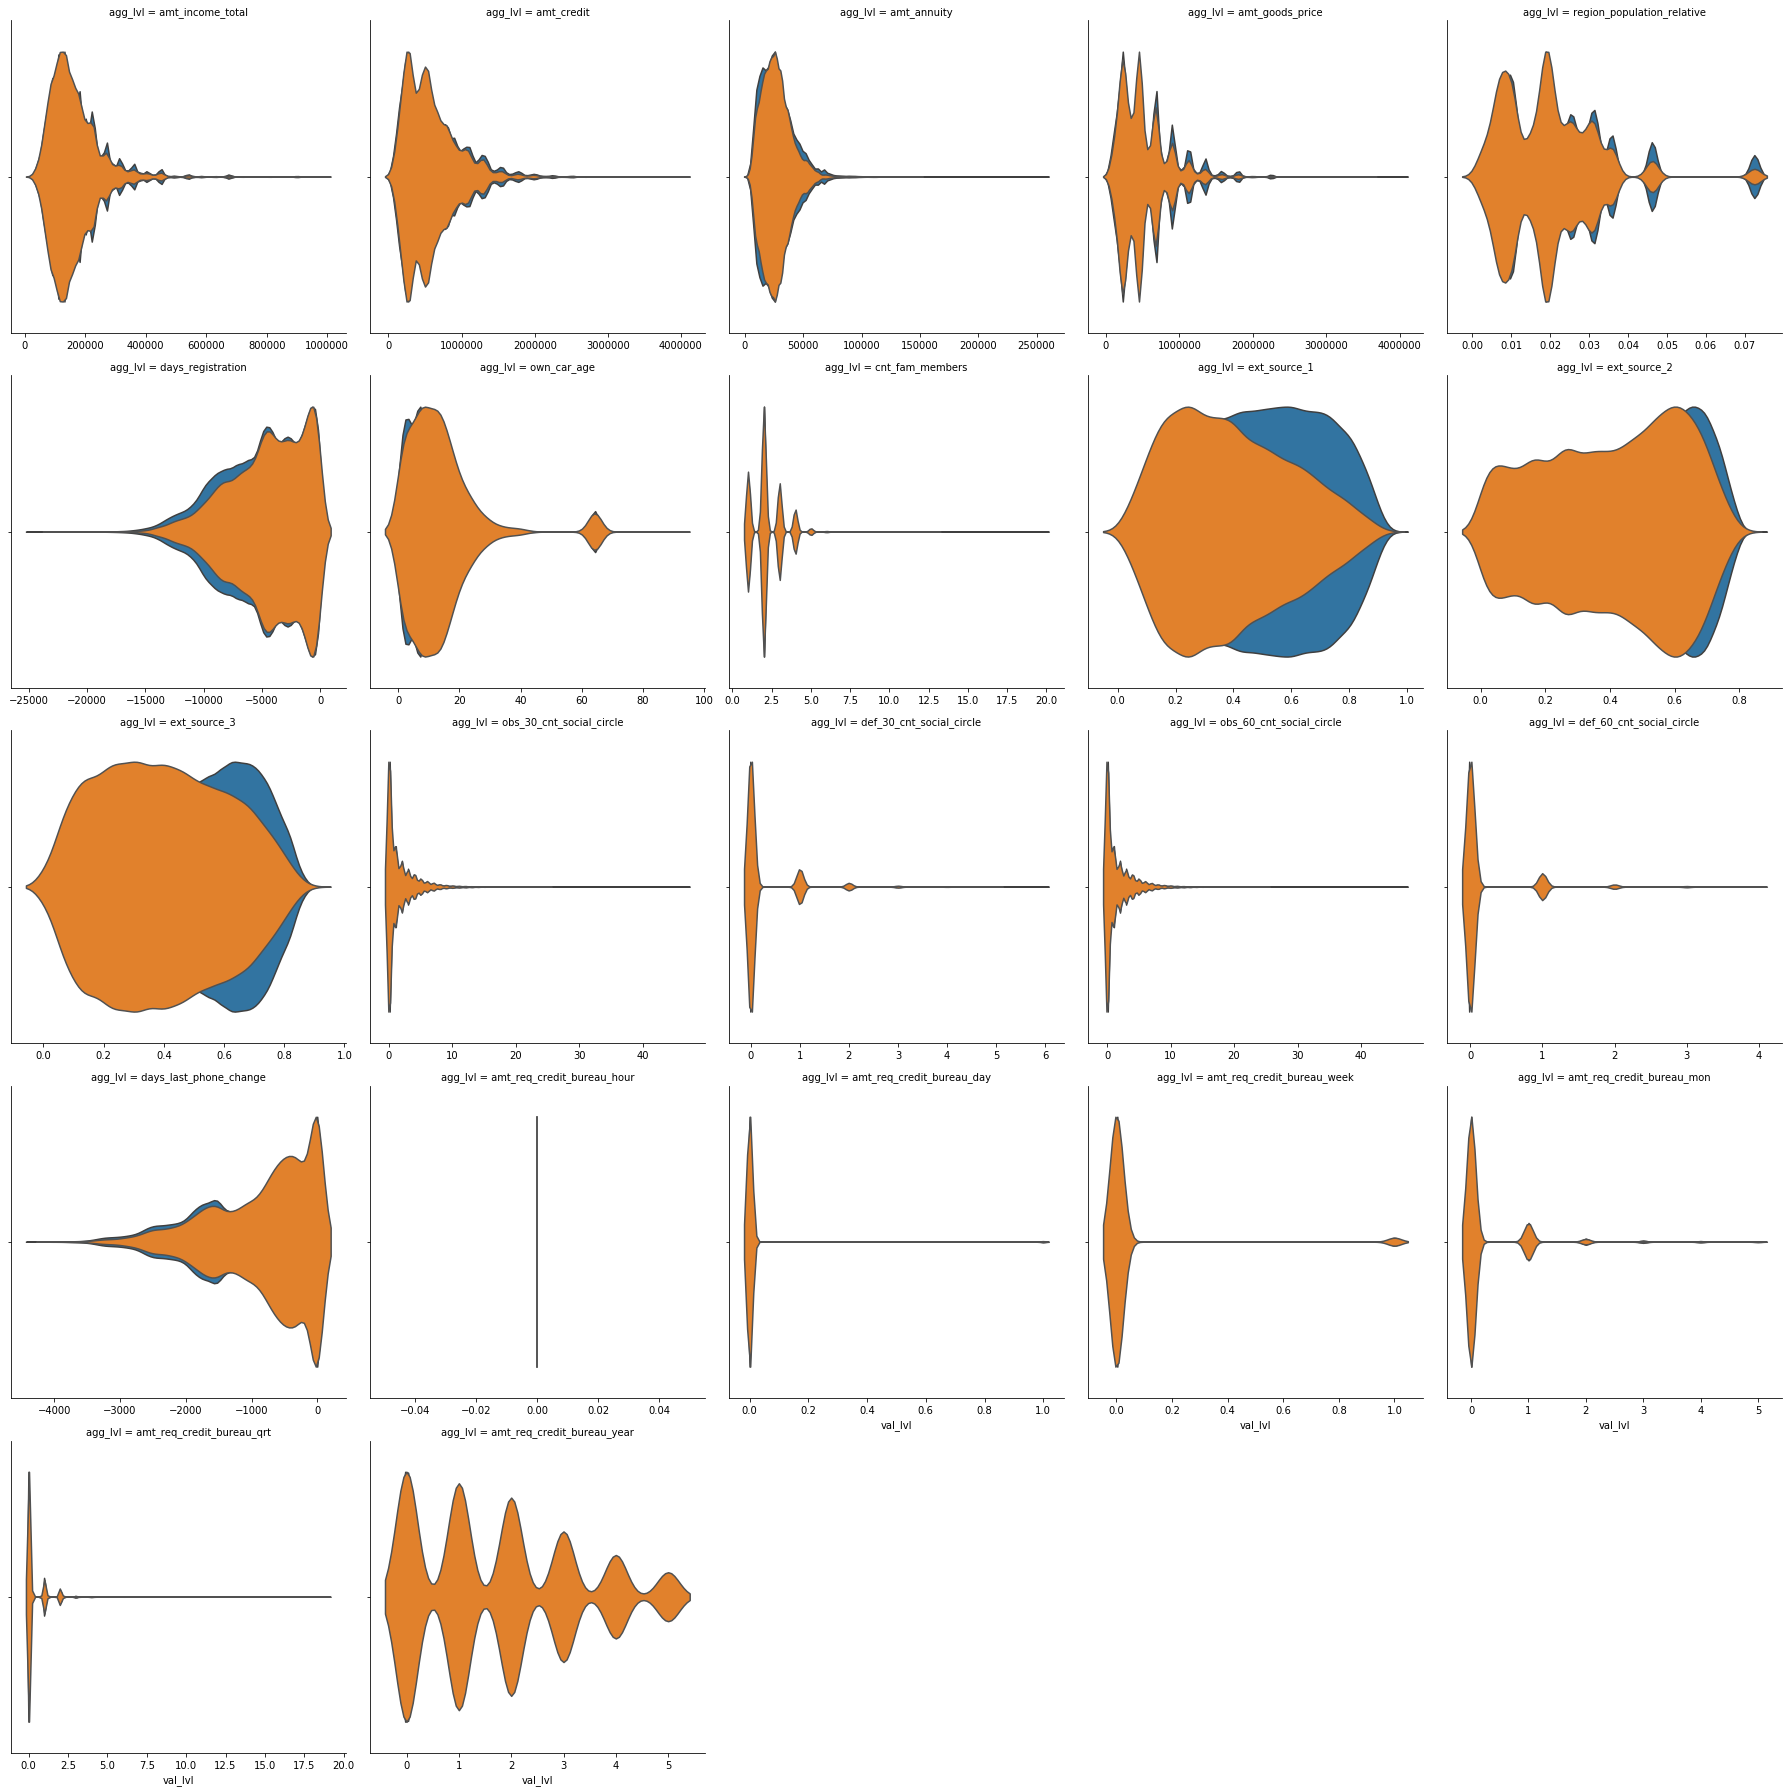

In [57]:
# Hold modified data
list_hld_grpby=list()

list_col_int_grpby=[col_name for col_name in list_col_float]

# Work through all discrete columns and calculate mean of target (Basically go from "wide" to "long")
for grp_col in list_col_int_grpby:
    df_agg_tmp_int=df_trf_applications_sub_v2[(df_trf_applications_sub_v2['f_outlier']==0) & (df_trf_applications_sub_v2[grp_col].notna())][['target', grp_col]]
    df_agg_tmp_int.rename(columns={grp_col:'val_lvl'}, inplace=True)
    df_agg_tmp_int['agg_lvl']=grp_col

    # Add to holder
    list_hld_grpby.append(df_agg_tmp_int)

# Combine to common
df_mlt_agg_float=pd.concat(list_hld_grpby,sort=True)

# Initialize grid
h=sns.FacetGrid(df_mlt_agg_float
                ,col='agg_lvl'
                ,hue='target'
                ,col_wrap=5
                ,height=5
               ,sharex=False
               ,sharey=True
               )

# Fill with seaborn objects
h=h.map(sns.violinplot,"val_lvl",inner=None)

plt.show()

### 4.3 Transform continous data

** Impute missing values:**
1. Scalar (Median/Mean)
2. Max occuring discrete values
3. Model impute of continious

In [58]:
def f_est_imp_model_ext_src(exec_f, indata, indata_meta, str_ext_src='3',re_estimate_est=False, return_est=True, str_path_persist_est="C:\\Users\\patblo\\Python\\Data\\Kaggle\\Credit Default\\models\\"):
    
    """
    This function creates a random forrest regressor and attemps to impute the missing values for variables ext_source_2 and ext_source_3. The function needs to have the 
    f_trf_applications_obj executed first since it imputes values into variables going into the model for the final impute. 
    
    The function returns a estimator (the model) and the columns used for making the predictions on the data
    
    """
    
    if exec_f:
        
        tick=time.time()

        #-------------------------------------
        # Check so we pick up either external
        # source variable 2 or 3
        #-------------------------------------
        if str_ext_src not in (['1', '3']):
            print ("Model variable parameter is not correct, ending....")
            return None
        
        else:
            df_temp=indata.copy()
            df_temp_meta=indata_meta.copy()
            
            
            print ("\nRunning impute model for variable ext_source_{}. Re-estimate classifier {}, return classifier object: {}\n".format(str_ext_src,re_estimate_est, return_est))

            #---------------------------
            # Prepp data + train/test
            #---------------------------

            # Get relevant data
            list_col_flg=[f_inp for f_inp in df_temp.columns if f_inp.find('_f_')>=0]
            list_col_woe=[woe for woe in df_temp.columns if woe.find('woe')>=0]
            df_temp=df_temp[df_temp['ext_source_'+str_ext_src].notna()][['sk_id_curr','ext_source_'+str_ext_src]+list_col_flg+list_col_woe].copy()
            
            # Design matrix columns + target variable
            X_col=df_temp[df_temp['ext_source_'+str_ext_src].notna()][[col for col in df_temp.columns if col not in (['ext_source_'+str_ext_src, 'sk_id_curr'])]].columns
            y='ext_source_'+str_ext_src
            
            # Split into train/validation - Note that we are taking notna() rows here to build the model on, isna() rows are imputed when applying model! 
            X_imp1_trn, X_imp1_valid, y_imp1_trn, y_imp1_valid=train_test_split(df_temp[X_col].values
                                                                               ,df_temp[y].values
                                                                               ,test_size=0.3
                                                                               ,random_state=1234)



            #---------------------------
            # Algo estimation
            #---------------------------
            if re_estimate_est:
                # Regressor
                clf_reg_mdl_imp=RandomForestRegressor(n_estimators=450, max_depth=6, max_features='auto',random_state=1234)

                # Fit data
                clf_reg_mdl_imp_fit=clf_reg_mdl_imp.fit(X_imp1_trn
                                                        ,y_imp1_trn)

                # Predict values, given estimator
                y_train_pred=clf_reg_mdl_imp_fit.predict(X_imp1_trn)
                y_valid_pred=clf_reg_mdl_imp_fit.predict(X_imp1_valid)

                # Cross validation of optimal GridSearch model
                cv_mdl_imp= cross_validate(clf_reg_mdl_imp_fit
                                                ,X_imp1_trn
                                                ,y_imp1_trn
                                                ,scoring='neg_mean_squared_error'
                                                ,cv=5

                                                ,n_jobs=-1)


                print ("Accuracy TRAIN: %0.3f (+/- %0.3f)" % (np.sqrt(-1*cv_mdl_imp['train_score']).mean(), np.sqrt(-1*cv_mdl_imp['train_score']).std() * 2))
                print ("Accuracy VALID: %0.3f (+/- %0.3f)" % (np.sqrt(-1*cv_mdl_imp['test_score']).mean(), np.sqrt(-1*cv_mdl_imp['test_score']).std() * 2))

                print("\nCV Score TRAIN : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(np.sqrt(-1*cv_mdl_imp['train_score'])), np.std(np.sqrt(-1*cv_mdl_imp['train_score'])), np.min(np.sqrt(-1*cv_mdl_imp['train_score'])), np.max(np.sqrt(-1*cv_mdl_imp['train_score']))))       
                print("CV Score VALID: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(np.sqrt(-1*cv_mdl_imp['test_score'])), np.std(np.sqrt(-1*cv_mdl_imp['test_score'])), np.min(np.sqrt(-1*cv_mdl_imp['test_score'])), np.max(np.sqrt(-1*cv_mdl_imp['test_score']))))       


                print ("\nTotal elapsed time is: {}s\n".format(round(time.time()-tick)))

                # We pickle the model to disk to save time of re-estimating it
                if str_path_persist_est:
                    from joblib import dump
                    print ("Persisting model to path: {}".format(str_path_persist_est))
                    dump(clf_reg_mdl_imp_fit, str_path_persist_est+'clf_reg_mdl_imp_ext_src_'+str_ext_src)
                    
            #--------------------------------------------------------------
            # Return re-estimated algo or load from persisted model file
            #--------------------------------------------------------------
            
            # Return the algo AFTER RE-ESTIMATION!
            if return_est and re_estimate_est:
                return clf_reg_mdl_imp_fit, X_col
            
            # Return PERSISTED ALGO!
            elif return_est and not re_estimate_est:
                from joblib import load
                return load(str_path_persist_est+'clf_reg_mdl_imp_ext_src_'+str_ext_src), X_col
            

    else:
        print ("No execution of algo for impute of data variable external_source_{}, ending....".format(str_ext_src))

In [59]:
def f_trf_applications_cont(exec_f, indata, indata_main):
    
    if exec_f:
    
        df_temp_meta=indata.copy()
        df_temp=indata_main.copy()
    
        #----------------------------------
        # Impute missing value: SCALAR
        #----------------------------------
        list_col_imp_mm=df_temp_meta[df_temp_meta['col_imp_strg']=='Median/Mean']['col_name'].tolist()

        # Fill with mean value, itterate through columns
        for idx_imp_mm, col_imp_mm in enumerate(list_col_imp_mm):
            print ("Imputing column {} with Mean value".format(col_imp_mm))
            df_temp[col_imp_mm].fillna(df_temp[col_imp_mm].mean(axis=0), inplace=True)

        print ("\n")
        list_col_imp_mvd=df_temp_meta[df_temp_meta['col_imp_strg']=='MaxValDisc']['col_name'].tolist()

        list_col_imp_mvd=df_temp_meta[df_temp_meta['col_imp_strg']=='MaxValDisc']['col_name'].tolist()

        # Most frequently occuring discrete value, itterate through columns
        for idx_imp_mvd, col_imp_mvd in enumerate(list_col_imp_mvd):
            df_agg_imp_temp=df_trf_applications_sub_v2[['sk_id_curr']+[col_imp_mvd]].groupby([col_imp_mvd], as_index=False).count()
            srs_imp_mvd=df_agg_imp_temp[df_agg_imp_temp['sk_id_curr']==df_agg_imp_temp['sk_id_curr'].max(axis=0)][col_imp_mvd]
            print ("Imputing column {} with Max value from discrete column: {}".format(col_imp_mvd, srs_imp_mvd[0]))

            df_temp[col_imp_mvd]=df_temp[col_imp_mvd].fillna(srs_imp_mvd[0])  

     
            
        # own_car_age: Impute as -99 and set flag has car 1/0
        df_temp['own_car_age'].fillna(-99, inplace=True)
        df_temp['inp_f_has_car']=np.where(df_temp['own_car_age']==-99
                                         ,0
                                         ,1)
        
        #--------------------------------
        # Impute missing value: Model 
        #--------------------------------
        
        # Ext_source_3
        est_imp_ext_src_3, X_col_ext_src_3=f_est_imp_model_ext_src(True, df_temp, df_temp_meta, str_ext_src='3',re_estimate_est=False, return_est=True, str_path_persist_est="C:\\Users\\patblo\\Python\\Data\\Kaggle\\Credit Default\\models\\")
        df_temp.loc[df_temp['ext_source_3'].isna(), 'ext_source_3']=est_imp_ext_src_3.predict(df_temp[df_temp['ext_source_3'].isna()][X_col_ext_src_3].values)

        # Ext_source_2
        est_imp_ext_src_1, X_col_ext_src_1=f_est_imp_model_ext_src(True, df_temp, df_temp_meta, str_ext_src='1',re_estimate_est=False, return_est=True, str_path_persist_est="C:\\Users\\patblo\\Python\\Data\\Kaggle\\Credit Default\\models\\")
        df_temp.loc[df_temp['ext_source_1'].isna(), 'ext_source_1']=est_imp_ext_src_1.predict(df_temp[df_temp['ext_source_1'].isna()][X_col_ext_src_1].values)

        
        #---------------------
        # amt_income_total
        #---------------------
        list_bin_inc_amt_tot=[grp for grp in range(0, 450000, 25000)]+[425001,1000000000]

        df_temp['inp_grp_amt_income_total']=pd.cut(df_temp['amt_income_total'], bins=list_bin_inc_amt_tot, include_lowest=False)
        df_temp['inp_grp_amt_income_total']=df_temp['inp_grp_amt_income_total'].cat.codes+1

        #-------------------
        # amt_credit
        #-------------------
        df_temp['inp_grp_amt_credit']=pd.qcut(df_temp['amt_credit'], 10)
        df_temp['inp_grp_amt_credit']=df_temp['inp_grp_amt_credit'].cat.codes+1

        
        #-------------------
        # amt_annuity
        #-------------------        
        df_temp['inp_grp_amt_annuity']=pd.qcut(df_temp['amt_annuity'], 20)
        df_temp['inp_grp_amt_annuity']=df_temp['inp_grp_amt_annuity'].cat.codes+1

        
        #-------------------
        # amt_good_price
        #-------------------                
        df_temp['inp_grp_amt_goods_price']=pd.qcut(df_temp['amt_goods_price'], 10)
        df_temp['inp_grp_amt_goods_price']=df_temp['inp_grp_amt_goods_price'].cat.codes+1


        #----------------------------
        # region_population_relative
        #----------------------------
        df_temp['inp_grp_region_population_relative']=pd.qcut(df_temp['region_population_relative'], 10)
        df_temp['inp_grp_region_population_relative']=df_temp['inp_grp_region_population_relative'].cat.codes+1
        
        
        #------------------------------
        # days_registration
        #------------------------------
        df_temp['inp_grp_days_registration']=pd.qcut(df_temp['days_registration'], 10)
        df_temp['inp_grp_days_registration']=df_temp['inp_grp_days_registration'].cat.codes+1


        #--------------------
        # own_car_age
        #--------------------
        list_bin_own_car_age=[-99]+[grp for grp in range(0,100,25)]

        df_temp['inp_grp_own_car_age']=pd.cut(df_temp['own_car_age'], list_bin_own_car_age)
        df_temp['inp_grp_own_car_age']=df_temp['inp_grp_own_car_age'].cat.codes+1

        
        #--------------------
        # cnt_fam_members
        #--------------------
        list_bin_cnt_fam_members=[0,1,2,4,50]

        df_temp['inp_grp_cnt_fam_members']=pd.cut(df_temp['cnt_fam_members'], bins=list_bin_cnt_fam_members, include_lowest=False)
        df_temp['inp_grp_cnt_fam_members']=df_temp['inp_grp_cnt_fam_members'].cat.codes+1


        #--------------------
        # ext_source_1
        #--------------------        
        df_temp['inp_grp_ext_source_1']=pd.qcut(df_temp['ext_source_1'], 10)
        df_temp['inp_grp_ext_source_1']=df_temp['inp_grp_ext_source_1'].cat.codes+1
        
        
        #--------------------
        # ext_source_2
        #--------------------                
        df_temp['inp_grp_ext_source_2']=pd.qcut(df_temp['ext_source_2'], 15)
        df_temp['inp_grp_ext_source_2']=df_temp['inp_grp_ext_source_2'].cat.codes+1
        
        

        #-------------------
        # ext_source_3
        #-------------------
        df_temp['inp_grp_ext_source_3']=pd.qcut(df_temp['ext_source_3'], 15)
        df_temp['inp_grp_ext_source_3']=df_temp['inp_grp_ext_source_3'].cat.codes+1
        
        
        #---------------------------
        # obs_30_cnt_social_circle
        #---------------------------
        list_bin_obs_30_cnt_social_circle=[0,1,2,3,4,5,10,505]

        df_temp['inp_grp_obs_30_cnt_social_circle']=pd.cut(df_temp['obs_30_cnt_social_circle'], bins=list_bin_obs_30_cnt_social_circle, include_lowest=True)
        df_temp['inp_grp_obs_30_cnt_social_circle']=df_temp['inp_grp_obs_30_cnt_social_circle'].cat.codes+1
        

        #----------------------------
        # obs_60_cnt_social_circle
        #----------------------------
        list_bin_obs_60_cnt_social_circle=[0,1,2,3,4,5,10,505]

        df_temp['inp_grp_obs_60_cnt_social_circle']=pd.cut(df_temp['obs_60_cnt_social_circle'], bins=list_bin_obs_60_cnt_social_circle, include_lowest=True)
        df_temp['inp_grp_obs_60_cnt_social_circle']=df_temp['inp_grp_obs_60_cnt_social_circle'].cat.codes+1


        #-------------------------------
        # def_30_cnt_social_circle
        #-------------------------------
        list_bin_def_30_cnt_social_circle=[0,1,2,50]

        df_temp['inp_grp_def_30_cnt_social_circle']=pd.cut(df_temp['def_30_cnt_social_circle'], bins=list_bin_def_30_cnt_social_circle, include_lowest=True)
        df_temp['inp_grp_def_30_cnt_social_circle']=df_temp['inp_grp_def_30_cnt_social_circle'].cat.codes+1
        
        
        
        #-------------------------------
        # def_60_cnt_social_circle
        #-------------------------------        
        list_bin_def_60_cnt_social_circle=[0,1,2,50]

        df_temp['inp_grp_def_60_cnt_social_circle']=pd.cut(df_temp['def_60_cnt_social_circle'], bins=list_bin_def_60_cnt_social_circle, include_lowest=True)
        df_temp['inp_grp_def_60_cnt_social_circle']=df_temp['inp_grp_def_60_cnt_social_circle'].cat.codes+1
        
        #-------------------------------
        # days_last_phone_change
        #-------------------------------        
        list_bin_days_last_phone_change=[-10000]+[grp*-1 for grp in range(100, 4000, 400)][::-1]+[grp*-1 for grp in range(0, 100, 20)][::-1]

        df_temp['inp_grp_days_last_phone_change']=pd.cut(df_temp['days_last_phone_change'], bins=list_bin_days_last_phone_change, include_lowest=True)
        df_temp['inp_grp_days_last_phone_change']=df_temp['inp_grp_days_last_phone_change'].cat.codes+1
        
        
        #-------------------------------
        # amt_req_credit_bureau_hour
        #-------------------------------                
        df_temp['f_inp_amt_req_credit_bureau_hour']=np.where(df_temp['amt_req_credit_bureau_hour']>0
                                                            ,1
                                                            ,0)
        

        #-------------------------------
        # amt_req_credit_bureau_day
        #-------------------------------                
        df_temp['f_inp_amt_req_credit_bureau_day']=np.where(df_temp['amt_req_credit_bureau_day']>0
                                                            ,1
                                                            ,0)

        
        
        #-------------------------------
        # amt_req_credit_bureau_week
        #-------------------------------                
        df_temp['f_inp_amt_req_credit_bureau_week']=np.where(df_temp['amt_req_credit_bureau_week']>0
                                                            ,1
                                                            ,0)
        

        #-------------------------------
        # amt_req_credit_bureau_mon
        #-------------------------------                        
        list_bin_amt_req_credit_bureau_mon=[grp for grp in range(0,4,1)]+[50]

        df_temp['inp_grp_amt_req_credit_bureau_mon']=pd.cut(df_temp['amt_req_credit_bureau_mon'], bins=list_bin_amt_req_credit_bureau_mon, include_lowest=True)
        df_temp['inp_grp_amt_req_credit_bureau_mon']=df_temp['inp_grp_amt_req_credit_bureau_mon'].cat.codes+1


        #-------------------------------
        # amt_req_credit_bureau_qrt
        #-------------------------------                        
        list_bin_amt_req_credit_bureau_qrt=[grp for grp in range(0,3,1)]+[500]

        df_temp['inp_grp_amt_req_credit_bureau_qrt']=pd.cut(df_temp['amt_req_credit_bureau_qrt'], bins=list_bin_amt_req_credit_bureau_qrt, include_lowest=True)
        df_temp['inp_grp_amt_req_credit_bureau_qrt']=df_temp['inp_grp_amt_req_credit_bureau_qrt'].cat.codes+1

        #-------------------------------
        # amt_req_credit_bureau_qrt
        #-------------------------------                                
        list_bin_amt_req_credit_bureau_year=[grp for grp in range(0,8,1)]+[500]

        df_temp['inp_grp_amt_req_credit_bureau_year']=pd.cut(df_temp['amt_req_credit_bureau_year'], bins=list_bin_amt_req_credit_bureau_year, include_lowest=True)
        df_temp['inp_grp_amt_req_credit_bureau_year']=df_temp['inp_grp_amt_req_credit_bureau_year'].cat.codes+1
        
        
        
        # Push back data
        return df_temp
        
    else:
        print ("No transformation of continious data, returning indata. Ending...")
        return indata

In [60]:
df_trf_applications_sub_v3=f_trf_applications_cont(True, df_overv_cont, df_trf_applications_sub_v2)

Imputing column amt_annuity with Mean value
Imputing column amt_goods_price with Mean value
Imputing column ext_source_2 with Mean value
Imputing column days_last_phone_change with Mean value


Imputing column obs_30_cnt_social_circle with Max value from discrete column: 0.0
Imputing column def_30_cnt_social_circle with Max value from discrete column: 0.0
Imputing column obs_60_cnt_social_circle with Max value from discrete column: 0.0
Imputing column def_60_cnt_social_circle with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_hour with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_day with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_week with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_mon with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_qrt with Max value from discrete column: 0.0
Imputing column amt_req_credit_bureau_year with Max value fro

### 4.4 Bin analysis prior to WoE

In [61]:
#------------------
# Logi development
#------------------

def f_RunBinAnalysis():

    df_temp=df_trf_applications_sub_v3[['sk_id_curr', 'target', 'amt_req_credit_bureau_year']].copy()
    display(df_temp[:5])

    sns.violinplot(x='target',y='amt_req_credit_bureau_year', data=df_temp, split=True)
    plt.show()

    print(f_show_col_desc('amt_req_credit_bureau_year'))

    display(df_temp['amt_req_credit_bureau_year'].value_counts())


    list_bin_amt_req_credit_bureau_year=[grp for grp in range(0,8,1)]+[500]

    # df_temp['inp_grp_amt_req_credit_bureau_year']=pd.qcut(df_temp['amt_req_credit_bureau_year'], 2)
    df_temp['inp_grp_amt_req_credit_bureau_year']=pd.cut(df_temp['amt_req_credit_bureau_year'], bins=list_bin_amt_req_credit_bureau_year, include_lowest=True)

    df_temp['inp_grp_amt_req_credit_bureau_year']=df_temp['inp_grp_amt_req_credit_bureau_year'].cat.codes+1

    print(df_temp['amt_req_credit_bureau_year'].describe())


    display(f_desc_aug(True, df_temp, ['target'], ['inp_grp_amt_req_credit_bureau_year'], None))

    list_col_cont_woe=['inp_grp_amt_req_credit_bureau_year']

    # Estimate WoE
    df_woe, df_iv=f_woe(True, df_temp, ['inp_grp_amt_req_credit_bureau_year'], {'sk_id_curr': 'count', 'target':['sum']})

    # We take the WoE data, set it to a dictionary so we can recode our gategorical variables
    dict_map_woe=f_dict_map_woe(True, df_woe, ['inp_grp_amt_req_credit_bureau_year'])

### 4.5 WoE and IV

In [62]:
list_col_cont=df_overv_cont['col_name'].tolist()

list_col_cont_woe=[[col for col in df_trf_applications_sub_v3.columns if col.find(col_find)>=0 and (col[0:3]=='inp' or col[0:2]=='f_')] for col_find in list_col_cont]
list_col_cont_woe=[col[0] for col in list_col_cont_woe]


# Estimate WoE
df_woe, df_iv=f_woe(True, df_trf_applications_sub_v3, list_col_cont_woe, {'sk_id_curr': 'count', 'target':['sum']})

# We take the WoE data, set it to a dictionary so we can recode our gategorical variables
dict_map_woe=f_dict_map_woe(True, df_woe, list_col_cont_woe)

Commencing calculation of WoE and IV for variable: inp_grp_amt_income_total
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_amt_income_total']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_amt_credit
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_amt_credit']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_amt_annuity
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_amt_annuity']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_amt_goods_price
Exeucting groupby function....

Aggregator variables are: 
['inp_grp_amt_goods_price']

Variables with functons are: 
{'sk_id_curr': 'count', 'target': ['sum']}
Commencing calculation of WoE and IV for variable: inp_grp_region_popula

In [63]:
for idx_map_woe, col_map_woe in enumerate(dict_map_woe.items()):
    print ("Mapping WoE variable: {}".format(col_map_woe[0]))
    
    df_trf_applications_sub_v3[col_map_woe[0]+'_woe']=df_trf_applications_sub_v3[col_map_woe[0]].map(col_map_woe[1])

Mapping WoE variable: inp_grp_amt_income_total
Mapping WoE variable: inp_grp_amt_credit
Mapping WoE variable: inp_grp_amt_annuity
Mapping WoE variable: inp_grp_amt_goods_price
Mapping WoE variable: inp_grp_region_population_relative
Mapping WoE variable: inp_grp_days_registration
Mapping WoE variable: inp_grp_own_car_age
Mapping WoE variable: inp_grp_cnt_fam_members
Mapping WoE variable: inp_grp_ext_source_1
Mapping WoE variable: inp_grp_ext_source_2
Mapping WoE variable: inp_grp_ext_source_3
Mapping WoE variable: inp_grp_obs_30_cnt_social_circle
Mapping WoE variable: inp_grp_def_30_cnt_social_circle
Mapping WoE variable: inp_grp_obs_60_cnt_social_circle
Mapping WoE variable: inp_grp_def_60_cnt_social_circle
Mapping WoE variable: inp_grp_days_last_phone_change
Mapping WoE variable: f_inp_amt_req_credit_bureau_hour
Mapping WoE variable: f_inp_amt_req_credit_bureau_day
Mapping WoE variable: f_inp_amt_req_credit_bureau_week
Mapping WoE variable: inp_grp_amt_req_credit_bureau_mon
Mapping W

### 4.6 Model
* Logistix regression
* Random Forrest
* XGBoost

In [64]:
X_trn=df_trf_applications_sub_v3[[flg for flg in df_trf_applications_sub_v3.columns if flg.find('inp_f')>=0]+[woe for woe in df_trf_applications_sub_v3.columns if woe.find('woe')>=0]].astype('float64').values
y=df_trf_applications_sub_v3['target'].astype('float64').values

X_trn, X_valid, y_trn, y_valid=train_test_split(X_trn
                                                ,y
                                                ,test_size=0.3
                                                ,random_state=1234
                                               ,stratify=y  
                                               )


Cross validation performance: 0.746 (+/- 0.009)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.96      0.72      0.82    197876
        1.0       0.17      0.64      0.27     17377

avg / total       0.89      0.72      0.78    215253

Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

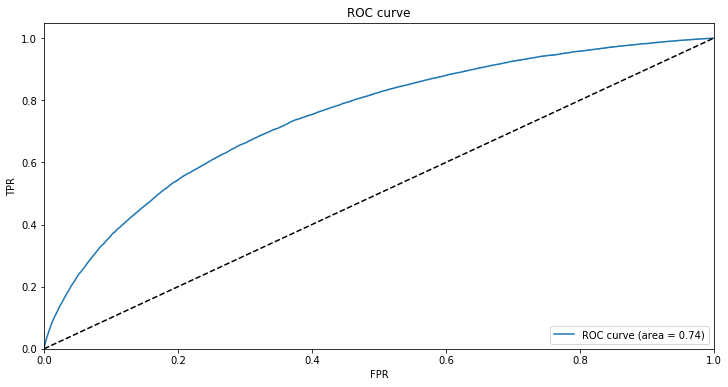

Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


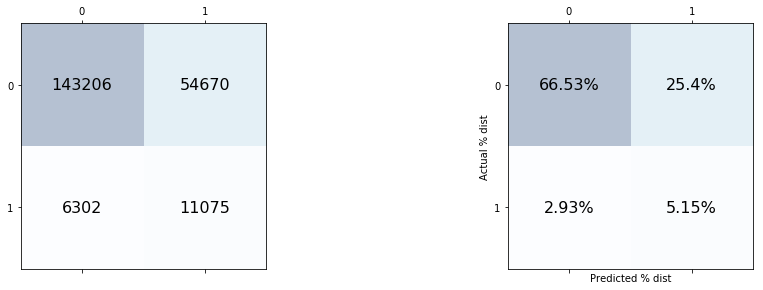


Total elapsed time:24.42s


In [65]:



tick=time.time()
#---------------------
# Logistic regression
#---------------------
clf_lr=linear_model.LogisticRegression(C=1, random_state=1234)

clf_lr_fit=clf_lr.fit(X_trn
                     ,y_trn)

y_trn_pred_lr=clf_lr_fit.predict_proba(X_trn)[:,1]

y_trn_predict_lr=clf_lr_fit.predict(X_trn)
y_trn_predict_lr=np.where(y_trn_pred_lr>0.09
                  ,1
                  ,0)


# Cross validation of model
cv_score_lr= cross_val_score(clf_lr_fit
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                        ,n_jobs=-1)

print("Cross validation performance: %0.3f (+/- %0.3f)" % (cv_score_lr.mean(), cv_score_lr.std() * 2))
print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_lr))

spr.f_roc_curve(y_trn, y_trn_pred_lr)
spr.f_conf_mtrx(True, y_trn, y_trn_predict_lr)

print ("\nTotal elapsed time:{}s".format(round(time.time()-tick, 2)))






C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Cross validation performance TRAIN: 0.765 (+/- 0.001)
Cross validation performance VALIDATION: 0.737 (+/- 0.004)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.96      0.71      0.81    197876
        1.0       0.17      0.68      0.27     17377

avg / total       0.90      0.70      0.77    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.96      0.70      0.81     84804
        1.0       0.16      0.64      0.26      7448

avg / total       0.89      0.70      0.77     92252

ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

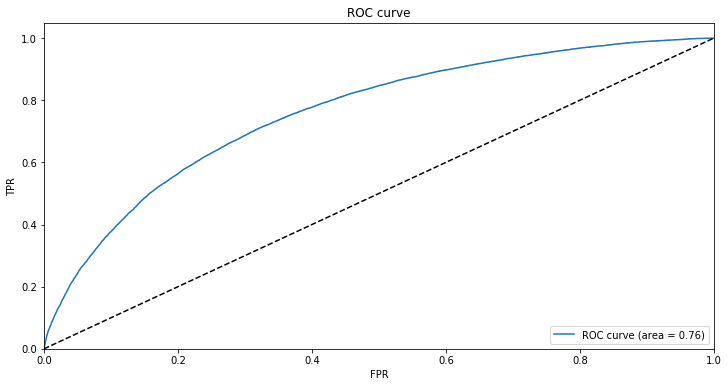

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

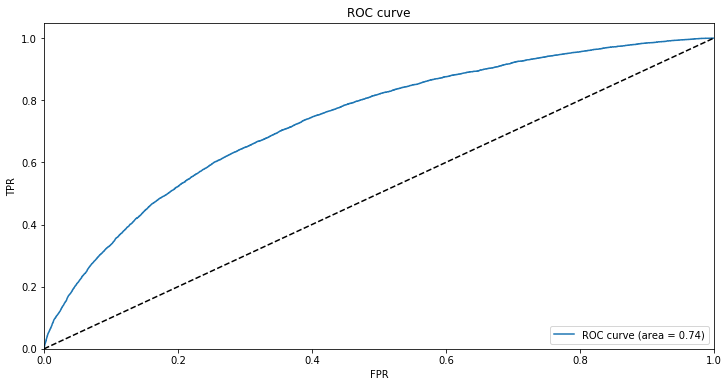

Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


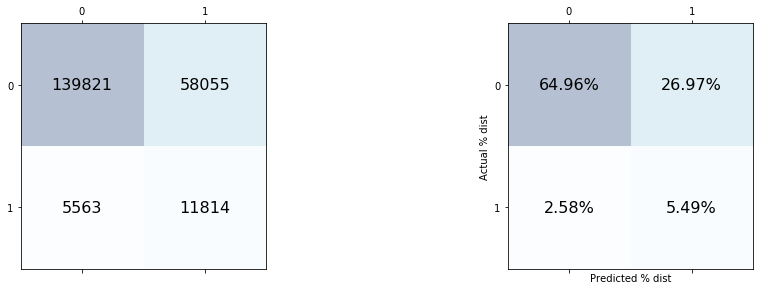

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


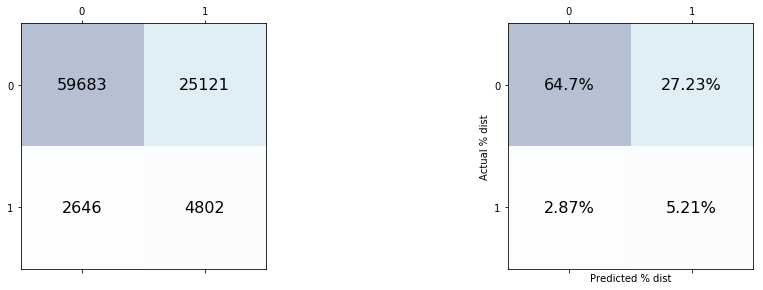


Total elapsed time is: 438s


In [66]:
tick=time.time()

#---------------------
# Random Forest
#---------------------
clf_rf=RandomForestClassifier(n_estimators=450, max_depth=8, min_samples_leaf=4,class_weight='balanced')
# clf_rf=RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_split=4, random_state=1234)
clr_rf_fit=clf_rf.fit(X_trn
                 ,y_trn)

y_trn_pred_rf=clr_rf_fit.predict_proba(X_trn)[:,1]
y_trn_predict_rf=clf_rf.predict(X_trn)

y_valid_pred_rf=clr_rf_fit.predict_proba(X_valid)[:,1]
y_valid_predict_rf=clf_rf.predict(X_valid)



# Cross validation of model
cv_rf= cross_validate(clf_rf
                        ,X_trn
                        ,y_trn
                        ,scoring='roc_auc'
                        ,cv=5
                        ,n_jobs=-1)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_rf['train_score'].mean(), cv_rf['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_rf['test_score'].mean(), cv_rf['test_score'].std()*2))

print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_rf))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_rf))

print ("ROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_rf)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_rf)

print ("Confusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_rf)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_rf)


print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\patblo\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Cross validation performance TRAIN: 0.791 (+/- 0.001)
Cross validation performance VALIDATION: 0.750 (+/- 0.006)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96    197876
        1.0       0.67      0.02      0.03     17377

avg / total       0.90      0.92      0.88    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     84804
        1.0       0.51      0.01      0.02      7448

avg / total       0.89      0.92      0.88     92252

ROC: TRAIN
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

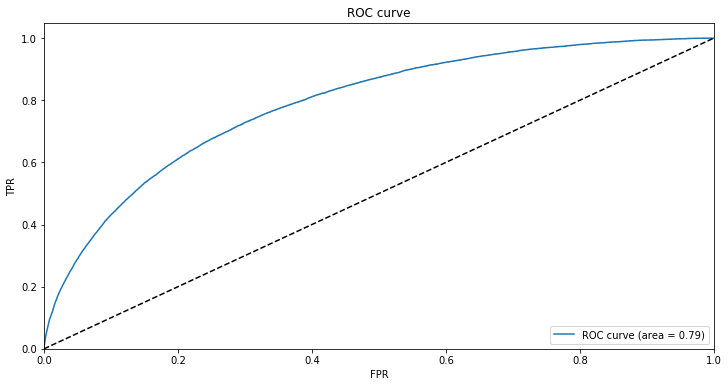

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

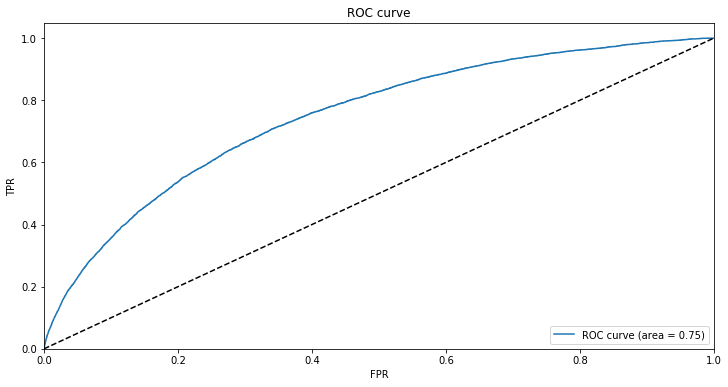

Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


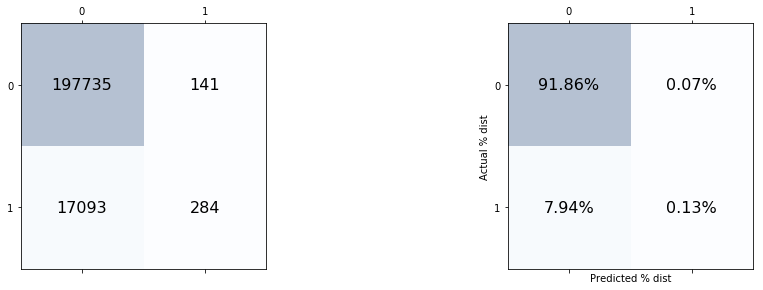

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


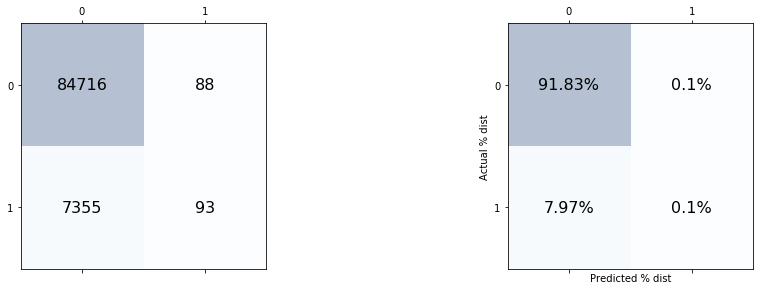


Total elapsed time is: 803s


In [67]:


tick=time.time()
#---------------------
# xgboost
#---------------------
clf_xgb_v1=xgbst.XGBClassifier(n_estimators=450, learning_rate=0.1,max_depth=4, objective='binary:logistic')

clf_xgb_v1_fit=clf_xgb_v1.fit(X_trn
                            ,y_trn)

y_trn_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_trn)[:,1]
y_trn_predict_xgb_v1=clf_xgb_v1.predict(X_trn)

y_valid_pred_xgb_v1=clf_xgb_v1_fit.predict_proba(X_valid)[:,1]
y_valid_predict_xgb_v1=clf_xgb_v1.predict(X_valid)


# Cross validation of model
cv_xgb_v1= cross_validate(clf_xgb_v1
                            ,X_trn
                            ,y_trn
                            ,scoring='roc_auc'
                            ,cv=StratifiedShuffleSplit(n_splits=5, random_state=1234)
                            ,n_jobs=-1)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))

print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1))

print ("ROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("Confusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1)


print ("\nTotal elapsed time is: {}s".format(round(time.time()-tick)))

Cross validation performance TRAIN: 0.791 (+/- 0.001)
Cross validation performance VALIDATION: 0.750 (+/- 0.006)

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.99      0.28      0.44    197876
        1.0       0.11      0.96      0.19     17377

avg / total       0.92      0.34      0.42    215253

Classification report TRAIN:
             precision    recall  f1-score   support

        0.0       0.98      0.28      0.44     84804
        1.0       0.10      0.94      0.19      7448

avg / total       0.91      0.33      0.42     92252


ROC: TRAIN


C:\Users\patblo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

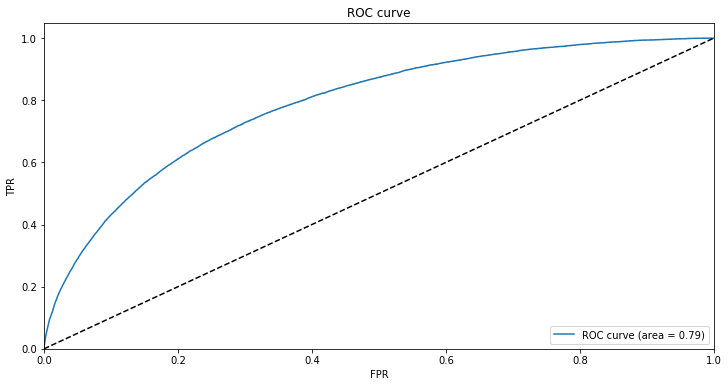

ROC: VALIDATION
Model prediction <class 'numpy.ndarray'> is of correct form, proceeding...


Model target variable <class 'numpy.ndarray'> is of correct form, proceeding...




<Figure size 432x288 with 0 Axes>

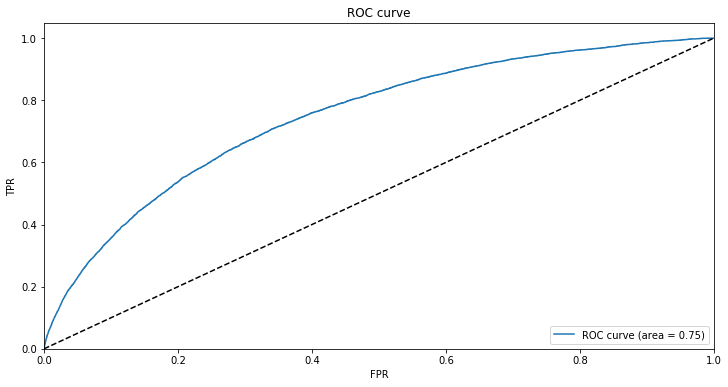


Confusion Matrix: TRAIN
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


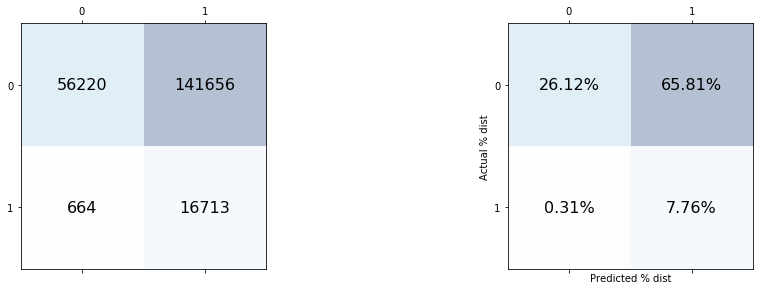

Confusion Matrix: VALIDATION
Executing function...


Target variable, y, has 2 distinct levels, proceeding with confusion matrix creation:


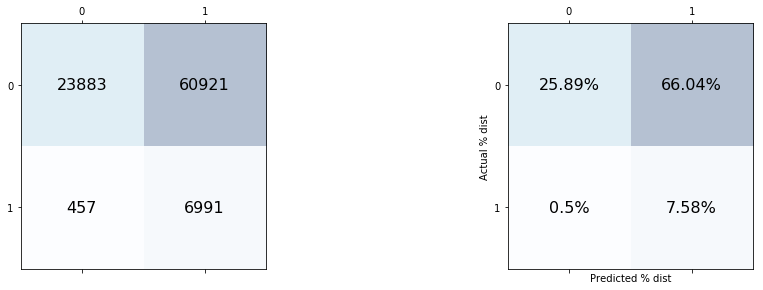

In [68]:
#-----------------------
# Customized cut-off
#-----------------------
y_trn_predict_xgb_v1_tune=np.where(y_trn_pred_xgb_v1>0.03
                                 ,1
                                 ,0)
y_valid_predict_xgb_v1_tune=np.where(y_valid_pred_xgb_v1>0.03
                                     ,1
                                     ,0)

print("Cross validation performance TRAIN: %0.3f (+/- %0.3f)" % (cv_xgb_v1['train_score'].mean(), cv_xgb_v1['train_score'].std()*2))
print("Cross validation performance VALIDATION: %0.3f (+/- %0.3f)" % (cv_xgb_v1['test_score'].mean(), cv_xgb_v1['test_score'].std()*2))


print ("\nClassification report TRAIN:")
print (classification_report(y_trn, y_trn_predict_xgb_v1_tune))
print ("Classification report TRAIN:")
print (classification_report(y_valid, y_valid_predict_xgb_v1_tune))

print ("\nROC: TRAIN")
spr.f_roc_curve(y_trn, y_trn_pred_xgb_v1)
print ("ROC: VALIDATION")
spr.f_roc_curve(y_valid, y_valid_pred_xgb_v1)

print ("\nConfusion Matrix: TRAIN")
spr.f_conf_mtrx(True, y_trn, y_trn_predict_xgb_v1_tune)
print ("Confusion Matrix: VALIDATION")
spr.f_conf_mtrx(True, y_valid, y_valid_predict_xgb_v1_tune)


plt.show()

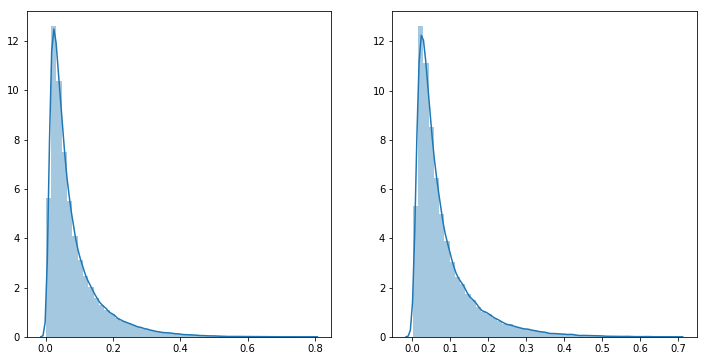

In [69]:
fig, ax=plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

sns.distplot(y_trn_pred_xgb_v1, ax=ax[0])
sns.distplot(y_valid_pred_xgb_v1, ax=ax[1])

plt.show()